# CS452/CS552 Assignment 2: Car Rollover Prediction

**Release Date: 23.11.2021** <br>
**Submission Deadline: 12.12.2021 23.55**

In [173]:
# Author: Eyüb Ensari Topcan
# Department: Industrial Engineering
# Degree: BSc.

In [174]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests as rq
import io
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 150)
random.seed(42) # DO NOT CHANGE
np.random.seed(42) # DO NOT CHANGE

# Part 1: Data Loading and Cleaning
> Get FARS datasets through the API provided by NHTSA using requests library.<br>

Two types of datasets will be used in the project:<br>
*person* dataset provides the information of persons involved in a crash.<br>
*vindecode* dataset the information of vehicles involved in a crash thanks to decoded Vehicle Identification Number (VIN).

In [3]:
api = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData"
case_years = np.arange(2014, 2020, dtype=int) # DO NOT CHANGE

In [4]:
def get_persons_data(year):
    response = rq.get(url = api, params = {'dataset':'person', 'caseYear':year, 'format':'csv'})

    if response.ok:
        csv_data = response.content
        persons = pd.read_csv(io.StringIO(csv_data.decode('utf-8')))
        return persons
    
    print("Failed to get the data")
    print(response.status)
    
    return None

def get_vehicles_data(year):
    response = rq.get(url = api, params = {'dataset':'vindecode', 'caseYear':year, 'format':'csv'})

    if response.ok:
        csv_data = response.content
        vehicles = pd.read_csv(io.StringIO(csv_data.decode('utf-8')))
        return vehicles
    
    print("Failed to get the data")
    print(response.status)
    
    return None

1.1) Use the above methods to get vehicles and persons datasets from 2014 to 2019.

In [5]:
# YOUR CODE HERE
persons2014 = get_persons_data(2014)
persons2015 = get_persons_data(2015)
persons2016 = get_persons_data(2016)
persons2017 = get_persons_data(2017)
persons2018 = get_persons_data(2018)
persons2019 = get_persons_data(2019)

vehicles2014 = get_vehicles_data(2014)
vehicles2015 = get_vehicles_data(2015)
vehicles2016 = get_vehicles_data(2016)
vehicles2017 = get_vehicles_data(2017)
vehicles2018 = get_vehicles_data(2018)
vehicles2019 = get_vehicles_data(2019)

persons = pd.concat([persons2014, persons2015, persons2016, persons2017, persons2018, persons2019], axis=0)

vehicles = pd.concat([vehicles2014, vehicles2015, vehicles2016, vehicles2017, vehicles2018, vehicles2019], axis=0)


KeyboardInterrupt: 

In [ ]:
persons

In [ ]:
for p in persons:
    print(p)

In [ ]:
vehicles

In [ ]:
for v in vehicles:
    print(v)

In [ ]:
for p in range(len(persons)-1):
    print(persons.columns[p], ":", persons.isnull().sum()[p])

In [ ]:
for v in range(len(vehicles)):
    print(vehicles.columns[v], ":", vehicles.isnull().sum()[v])

1.2) Determine the useless columns to drop from the dataframes.

**Hint 1**: An encoded and a decoded (actual-valued) column exist for most of the features. Drop the encoded columns.<br>
**Hint 2**: Some features have mostly null values or a single value. <br>
**Hint 3**: Some features provides information that can be obtained after the accident. <br>
You can refer to [FARS User’s Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813023) if needed.

In [ ]:
# Be aware that this is a mutable method.
def drop_useless_columns(vehicles, persons):
    #Dropping columns that has too many null values.
    vec_cols_to_drop = ["state", "vintrim1_t", "vintrim2_t", "vintrim3_t", "vintrim4_t", 
                        "cycles", "fuelinj", "fuelinj_t", "carbbrls", "gvwrange", "gvwrange_t", 
                        "tiredesc_f",  "tiresz_f", "tiresz_f_t", "tiredesc_r", "rearsize", "rearsize_t", 
                        "tonrating", "salectry", "salectry_t", "tkcab", "tkcab_t", "tkaxlef", "tkaxlef_t", 
                        "tkaxler", "tkaxler_t", "tkbrak", "tkbrak_t", "engmfg", "engmfg_t", "engmodel", "tkduty", 
                        "tkduty_t", "tkbedl", "tkbedl_t", "plntstat", "plntstat_t", "enghead", "enghead_t",  
                        "battyp", "battyp_t", "batkwrtg",  "batvolt", "supchrgr", "supchrgr_t", "turbo", "turbo_t",
                        "engvvt", "mcyusage", "mcyusage_t"   ] # fullfill the list with some column names of vehicles df
    
    per_cols_to_drop = ["state", "county", "road_fnc", "road_fncname", "make", "makename", "mak_mod", "body_typ", 
                        "body_typname", "mod_year", "mod_yearname", "tow_veh", "tow_vehname", "spec_use", 
                        "spec_usename", "emer_use", "emer_usename", "impact1", "impact1name", 
                        "fire_exp", "fire_expname", "drugtst1", "drugtst1name", "drugres1", "drugres1name", 
                        "drugtst2", "drugtst2name", "drugres2","drugres2name", "drugtst3", "drugtst3name", 
                        "drugres3", "drugres3name", "death_da", "death_daname", "death_mo", "death_moname", 
                        "death_yr", "death_yrname", "death_hr", "death_hrname", "death_mn", "death_mnname",
                        "cert_no","race","racename","func_sys","func_sysname","rur_urb","rur_urbname"] # fullfill the list with some column names of persons df

    vehicles.drop(vec_cols_to_drop, axis=1, inplace=True)
    persons.drop(per_cols_to_drop, axis=1, inplace=True)

In [ ]:
vehicles_copy = vehicles.copy()
persons_copy = persons.copy()
drop_useless_columns(vehicles_copy, persons_copy)

print(vehicles_copy.shape)
print(persons_copy.shape)

# YOUR CODE HERE

1.3.1) Complete the following method returning a single DataFrame named 'accidents' whose rows are singular for person and vehicle data. Then, merge the dataframes belongs to the same year.

**Hint 1**: You need to define a key from some columns like year, st_case, and veh_no to have an unique value for each row. <br>
**Hint 2**: You might use such methods ```<DataFrame>.merge```, ```<DataFrame>.join```, or ```pd.concat```.

In [ ]:
def merge_vehicles_and_persons(vehicles, persons) -> pd.DataFrame:
    
    # YOUR CODE HERE
    accidents = vehicles.merge(persons, how='inner', on= ['caseyear', 'st_case', 'veh_no', 'statename'])
    
    return accidents

In [ ]:
accidents = merge_vehicles_and_persons(vehicles_copy, persons_copy)

In [ ]:
# YOUR CODE HERE

1.3.2) Obtain a single dataframe named 'data' by merging accidents dataframes of all available years. There might be some columns which do not present in all years. <br> 
Save this dataframe as a csv or xlsx file so that after having the final data you can skip the previous steps while doing the assignment.


## Dropping during and after crashes data
You cannot use information which becomes available during or after crash such as crash location, weather, in which direction vehicle crashed, etc.

In [ ]:
useless_columns = ["alc_detname","alc_statusname","atst_typname","alc_resname","locationname","location", "atst_typname" ,"minute", "day", "month", "monthname", "hour", "str_veh", "harm_ev", "man_coll", "sch_bus", "age", "sex", "per_typ", "inj_sev", "seat_pos", "rest_use", "rest_mis", "air_bag", "ejection", "ej_path", "drinking", "alc_det", "alc_status", "atst_typ", "alc_res", "drugs", "drug_det", "dstatus", "p_sf1", "p_sf2", "p_sf3", "work_inj","hispanic", "hospital", "hospitalname", "doa", "doaname", "death_tm", "lag_hrs", "lag_mins", "extricat", "extricatname", "p_sf1name", "p_sf2name", "p_sf3name", "vehtype", "fuel", "drivetyp", "abs", "security", "drl", "rstrnt", "segmnt", "plant", "origin", "psi_f", "psi_r", "veh_no", "plntctry", "dispclmt"]
accidents.drop(useless_columns, axis=1, inplace=True)  # "vintrim_t", "abs_t", "drl_t", "security_t", "whlblg"

In [ ]:
# Read the saved final data file as a DataFrame.
# Remark: Your final dataset should comprise approximately 60 columns. 

accidents.to_csv(r'C:\Users\MONSTER\CS452\fars.csv', index = False)

In [175]:
data = pd.read_csv("fars.csv")

C:\Users\MONSTER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [176]:
data

,caseyear,statename,st_case,ncicmake,vinyear,vehtype_t,vinmake_t,vinmodel_t,vintrim_t,bodystyl,bodystyl_t,doors,wheels,drivwhls,mfg,mfg_t,displci,displcc,cylndrs,fuel_t,carbtype,carbtype_t,whlbsh,whlblg,shipweight,msrp,drivetyp_t,abs_t,security_t,drl_t,rstrnt_t,segmnt_t,plntctry_t,plntcity,origin_t,blocktype,vlvclndr,vlvtotal,engvincd,incomplt,ve_forms,per_no,str_vehname,countyname,hourname,minutename,harm_evname,man_collname,sch_busname,rollover,rollovername,agename,sexname,per_typname,inj_sevname,seat_posname,rest_usename,rest_misname,air_bagname,ejectionname,ej_pathname,drinkingname,drugsname,drug_detname,dstatusname,work_injname,hispanicname
0,2014,Alabama,10001,TOYT,2011.0,Passenger Car,TOYOTA,COROLLA,BASE,SD,Sedan,4.0,4.0,2.0,C175,TOYOTA,110.0,0.0,4.0,Gas,F,Fuel Injection,102.4,102.4,2734.0,15600.0,Front Wheel Drive,All Wheel Std,Immobilizer and keyless entry,Standard,Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,Non Luxury Traditional Compact,Canada,CAMBRIDGE,Import Built in North America,In-Line,4.0,16.0,U,N,1,1,Occupant of a Motor Vehicle,JACKSON (71),1:00am-1:59am,15,Boulder,Not a Collision with Motor Vehicle In-Transport,No,1.0,"Rollover, Tripped by Object/Vehicle",24 Years,Male,Driver of a Motor Vehicle In-Transport,Fatal Injury (K),"Front Seat, Left Side",Shoulder and Lap Belt Used,No,Deployed- Combination,Not Ejected,Not Ejected/Not Applicable,Yes (Alcohol Involved),Unknown,Not Reported,Test Given,No,Non-Hispanic
1,2014,Alabama,10001,TOYT,2011.0,Passenger Car,TOYOTA,COROLLA,BASE,SD,Sedan,4.0,4.0,2.0,C175,TOYOTA,110.0,0.0,4.0,Gas,F,Fuel Injection,102.4,102.4,2734.0,15600.0,Front Wheel Drive,All Wheel Std,Immobilizer and keyless entry,Standard,Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,Non Luxury Traditional Compact,Canada,CAMBRIDGE,Import Built in North America,In-Line,4.0,16.0,U,N,1,2,Occupant of a Motor Vehicle,JACKSON (71),1:00am-1:59am,15,Boulder,Not a Collision with Motor Vehicle In-Transport,No,1.0,"Rollover, Tripped by Object/Vehicle",30 Years,Female,Passenger of a Motor Vehicle In-Transport,Suspected Minor Injury(B),"Front Seat, Right Side",Shoulder and Lap Belt Used,No,Deployed- Combination,Not Ejected,Not Ejected/Not Applicable,Not Reported,Not Reported,Not Reported,Test Not Given,Not Applicable (not a fatality),Not A Fatality (not Applicable)
2,2014,Alabama,10002,DODG,1997.0,Truck,DODGE,RAM 2500,NaN,PK,Pickup,2.0,4.0,2.0,C127,DAIMLER-CHRYSLER,360.0,0.0,8.0,Gas,F,Fuel Injection,138.7,154.7,4787.0,20775.0,Rear Wheel Drive,Other Std,Unknown,Not Available,Driver Front Air Bag/Passenger Active Belts,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,LAGO ALBERTO,Domestic,V-type,2.0,16.0,Z,N,1,1,Occupant of a Motor Vehicle,FRANKLIN (59),1:00pm-1:59pm,30,Tree (Standing Only),Not a Collision with Motor Vehicle In-Transport,No,0.0,No Rollover,52 Years,Male,Driver of a Motor Vehicle In-Transport,Fatal Injury (K),"Front Seat, Left Side",None Used,No,Deployed- Front,Not Ejected,Not Ejected/Not Applicable,Yes (Alcohol Involved),No (drugs not involved),Not Reported,Test Given,No,Non-Hispanic
3,2014,Alabama,10003,CHEV,2004.0,Passenger Car,CHEVROLET,MALIBU,LT,SD,Sedan,4.0,0.0,0.0,C137,GENERAL MOTORS,214.0,0.0,6.0,Gas,F,Fuel Injection,106.3,106.3,3315.0,23495.0,Front Wheel Drive,All Wheel Std,Pass Key,Standard,Dual Air Bags Front and Sides/Active Belts,Non Luxury Traditional Mid Size,United States,FAIRFAX,Domestic,V-type,0.0,0.0,8,N,2,1,Occupant of a Motor Vehicle,TUSCALOOSA (125),3:00am-3:59am,7,Motor Vehicle In-Transport,Angle,No,0.0,No Rollover,22 Years,Male,Driver of a Motor Vehicle In-Transport,Suspected Minor Injury(B),"Front Seat, Left Side",None Used,No,Not Deployed,Not Ejected,Not Ejected/Not Applicable,Unknown (Police Reported),Unknown,Not Reported,Test Not Given,Not Applicable (not a fatality),Not A Fatality (not Applicable)
4,2014,Alabama,10003,CHEV,2004.0,Passenger Car,CHEVROLET,MALIBU,LT,SD,Sedan,4.0,0.0,0.0,C137,GENERAL MOTORS,214.0,0.0,6.0,Gas,F,Fuel Injection,106.3,106.3,3315.0,23495.0,Front Wheel Drive,

In [177]:
for d in range(len(data)):
    print(data.columns[d],":",data.isnull().sum()[d])

caseyear : 0
statename : 0
st_case : 0
ncicmake : 15705
vinyear : 15705
vehtype_t : 15705
vinmake_t : 15705
vinmodel_t : 15729
vintrim_t : 107240
bodystyl : 15705
bodystyl_t : 15705
doors : 15705
wheels : 15705
drivwhls : 15705
mfg : 26034
mfg_t : 26466
displci : 15705
displcc : 15705
cylndrs : 16418
fuel_t : 50056
carbtype : 81313
carbtype_t : 81313
whlbsh : 83955
whlblg : 83957
shipweight : 15705
msrp : 15705
drivetyp_t : 50501
abs_t : 94201
security_t : 87406
drl_t : 90162
rstrnt_t : 81733
segmnt_t : 49973
plntctry_t : 20400
plntcity : 26003
origin_t : 16499
blocktype : 81764
vlvclndr : 15705
vlvtotal : 15705
engvincd : 43976
incomplt : 15705
ve_forms : 0
per_no : 0
str_vehname : 0
countyname : 0
hourname : 0
minutename : 0
harm_evname : 0
man_collname : 0
sch_busname : 0
rollover : 0
rollovername : 0
agename : 0
sexname : 0
per_typname : 0
inj_sevname : 0
seat_posname : 0
rest_usename : 0
rest_misname : 0
air_bagname : 0
ejectionname : 0
ej_pathname : 0
drinkingname : 0
drugsname :

IndexError: index 67 is out of bounds for axis 0 with size 67

#  Part-2: Exploratory Data Analysis (EDA)

> In this part, explore categorical and numerical features and report some prominent characteristics of data.<br>
Try to get insights from the data for the feature engineering part.<br>

>Before the analysis, inspect the target variable.<br>
Decide on what type of problem is better to learn the car rollover phenomenon by ML models.<br>
Setting problem type is an crucial decision for achievements of ML projects.<br>
**Hint**: You should take an action changing the target variable.<br>
- Detecting missing values, e.g. 0, NaN, 999, -1, representative words (unknown, unavailable, etc.), ...
- Dropping duplicate and empty rows/columns
- histograms, scatter and bar plots
- value counts of categorical features
- statistical tables

In [178]:
# Do not include record identifier columns (e.g. st_case, veh_no, etc.) into the following lists!

categorical = ["statename","ncicmake","vehtype_t","vinmake_t","vinmodel_t","vintrim_t","bodystyl","bodystyl_t",
               "mfg","mfg_t","cylndrs","fuel_t","carbtype","carbtype_t","drivetyp_t","abs_t","security_t","drl_t","rstrnt_t",
               "segmnt_t","plntctry_t","plntcity","origin_t","blocktype","engvincd","incomplt","str_vehname","countyname",
               "hourname","minutename","harm_evname","man_collname","sch_busname","agename","sexname","per_typname","inj_sevname",
               "seat_posname","rest_usename","rest_misname","air_bagname","ejectionname","ej_pathname","drinkingname","drugsname",
               "drug_detname","dstatusname","work_injname","hispanicname"] # names of columns having categorical values

numeric = ["caseyear", "st_case", "vinyear", "doors", "wheels", "drivwhls", "displci", "displcc", "whlbsh", "whlblg", 
           "shipweight", "msrp", "vlvclndr", "vlvtotal", "ve_forms", "per_no", "rollover"] # names of columns having numerical values

target_name = "rollovername" # set the column name of target variable (it is named 'rollovername' in FARS datasets) 

#YOUR CODE HERE

features = categorical + numeric

In [179]:
print(data.shape)
data = data.drop_duplicates()
print(data.shape)

(452910, 67)
(452760, 67)


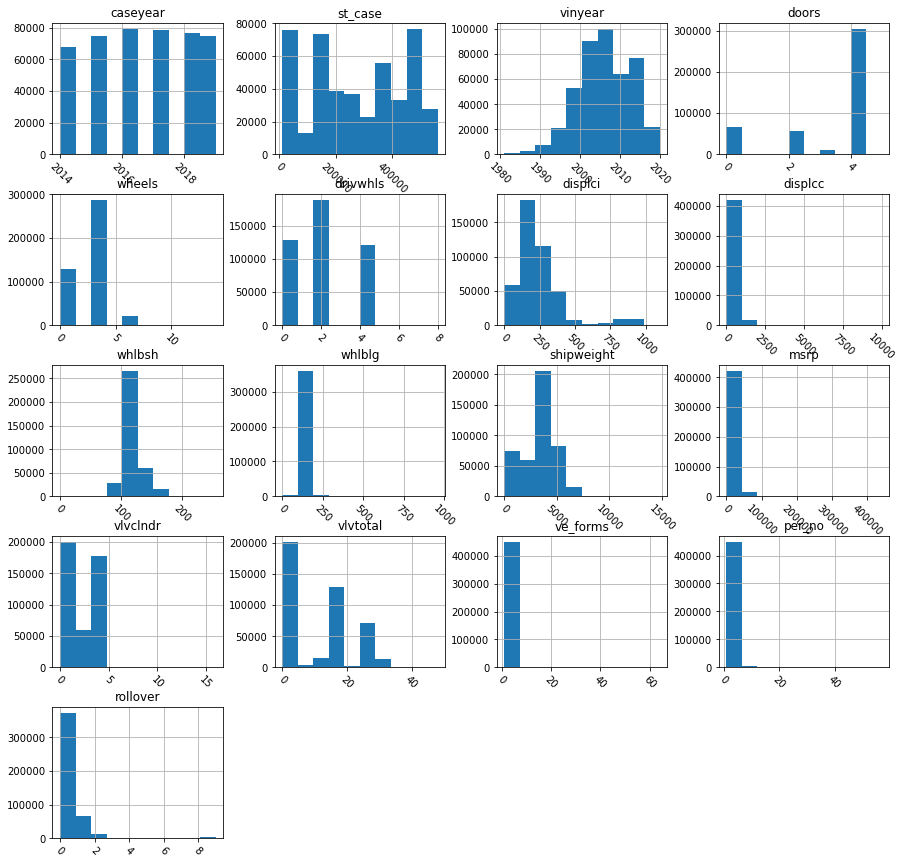

In [180]:
data.hist(figsize=(15,15), xrot=-45)
plt.show()

In [ ]:
plt.plot(data["shipweight"],data["rollovername"])
plt.title("shipweight vs rollover")
plt.show()

In [181]:
data.shape

(452760, 67)

<AxesSubplot:>

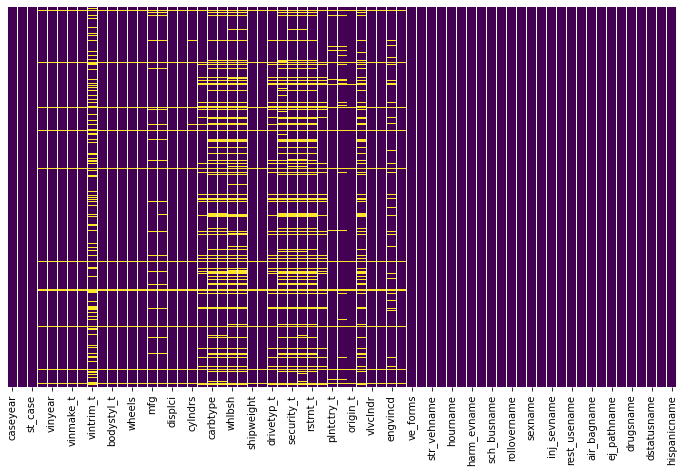

In [182]:
plt.figure(figsize=(12, 7))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

for col in data.columns:
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='rollovername',y=col,data=data,palette='winter')

In [183]:
#Categorical columns visualization

In [184]:
#countplot, jointplot, bar

#  Part-3: Data Cleaning and Feature Engineering

### 3.1. Handling with Missing Values: Dropping and/or Imputation
> You may drop some rows and columns.<br>
> Imputation with statistical values (mean, median, mode)<br>
> Imputation with a keyword like missing, unknown, etc.<br>

In [185]:
data.isnull().sum().sort_values(ascending=False)

vintrim_t       107091
abs_t            94051
drl_t            90012
security_t       87256
whlblg           83807
                 ...  
per_no               0
ve_forms             0
statename            0
st_case              0
hispanicname         0
Length: 67, dtype: int64

In [204]:
columns_with_null_values = ["vintrim_t", "abs_t", "drl_t", "security_t", "whlblg", "whlbsh", "blocktype", "rstrnt_t", "carbtype", "carbtype_t", "ncicmake","bodystyl"]
data.drop(columns_with_null_values, axis=1, inplace=True)

KeyError: "['vintrim_t' 'abs_t' 'drl_t' 'security_t' 'whlblg' 'whlbsh' 'blocktype'\n 'rstrnt_t' 'carbtype' 'carbtype_t' 'ncicmake' 'bodystyl'] not found in axis"

In [205]:
col_list = data.columns

In [206]:
#Dropping has so many unique entries

for c in col_list:
    print(c,"", data[c].nunique())
    
data.drop(["st_case", "vinmodel_t", "str_vehname", "plntcity", "drug_detname",'man_collname'], axis=1, inplace=True)

caseyear  6
statename  52
vinyear  40
vehtype_t  4
vinmake_t  167
bodystyl_t  45
doors  5
wheels  8
drivwhls  5
mfg  53
mfg_t  45
displci  642
cylndrs  19
fuel_t  12
shipweight  4762
msrp  10758
drivetyp_t  6
segmnt_t  34
plntctry_t  35
origin_t  5
vlvclndr  9
vlvtotal  16
engvincd  2509
incomplt  2
ve_forms  28
per_no  57
countyname  2979
hourname  25
minutename  121
harm_evname  60
sch_busname  2
rollover  4
rollovername  2
agename  112
sexname  5
per_typname  4
inj_sevname  11
seat_posname  30
rest_usename  23
rest_misname  5
air_bagname  12
ejectionname  8
ej_pathname  12
drinkingname  5
drugsname  5
dstatusname  6
work_injname  4
hispanicname  9


KeyError: "['st_case' 'vinmodel_t' 'str_vehname' 'plntcity' 'drug_detname'\n 'man_collname'] not found in axis"

In [312]:
data.drop("inj_sevname", axis=1,inplace=True)

C:\Users\MONSTER\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [313]:
col_list = data.columns
print(len(col_list))

42


In [314]:
for c in col_list:
    print(c)
    print(data[c].unique())
    #col_len = len(print(data[c].unique()))
    print("")

caseyear
[2014 2015 2016 2017 2018 2019]

statename
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', ..., 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Length: 52
Categories (52, object): ['Alabama', 'Alaska', 'Arizona', 'Arkansas', ..., 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

vinyear
[2011. 1997. 2004. 1999. 2010. 2005. 1995. 2014. 2009. 2001. 1992. 2003.
 2012. 1994. 1998. 2002. 2000. 2006. 2007. 1986. 2013. 1996. 2008. 1983.
 1989. 1993. 1990. 1991. 1988. 1987. 2015. 1984. 1985. 1981. 1982. 2016.
 2017. 2018. 2019. 2020.]

vehtype_t
['Passenger Car', 'Truck']
Categories (2, object): ['Passenger Car', 'Truck']

bodystyl_t
['STANDARD', 'TRUCK', 'VAN', 'SPORT', 'OTHER', 'INCOMPLETE', 'BUS']
Categories (7, object): ['STANDARD', 'TRUCK', 'VAN', 'SPORT', 'OTHER', 'INCOMPLETE', 'BUS']

doors
[4. 2. 3. 0. 5.]

wheels
[ 4.  0.  6.  2.  8. 10. 14.]

drivwhls
[2. 0. 4. 6. 8.]

mfg_t
['TOYOTA', 'DAIMLER-CHRYSLER', 'GENERAL MOTORS', 'FORD', 'PACCAR'

['No', 'Yes']
Categories (2, object): ['No', 'Yes']

air_bagname
['Deployed', 'Not Deployed']
Categories (2, object): ['Deployed', 'Not Deployed']

ejectionname
['Not Ejected', 'Totally Ejected', 'Partially Ejected', 'Unknown if Ejected', 'Not Applicable', 'Not Reported', 'Ejected - Unknown Degree', 'Reported as Unknown if Ejected']
Categories (8, object): ['Not Ejected', 'Totally Ejected', 'Partially Ejected', 'Unknown if Ejected', 'Not Applicable', 'Not Reported', 'Ejected - Unknown Degree', 'Reported as Unknown if Ejected']

ej_pathname
['Not Ejected/Not Applicable', 'Unknown/Unknown Path', 'Through Back Window', 'Through Roof Opening (sun-roof, convertible t..., 'Through Side Window', ..., 'Through Windshield', 'Through roof (convertible top up)', 'Through Back Door/Tailgate Opening', 'Ejection Path Not Applicable', 'Ejection Path Unknown']
Length: 12
Categories (12, object): ['Not Ejected/Not Applicable', 'Unknown/Unknown Path', 'Through Back Window', 'Through Roof Opening (sun-ro

## Converting cc to ci & Dropping displcc column

In [315]:
print(data[["displci", "displcc"]])

print(data["displci"].sum().round(2))
data["displci"] = data["displci"] + (data["displcc"]/16.39)
print(data["displci"].sum().round(2))

data.drop("displcc", axis=1, inplace = True)

KeyError: "['displcc'] not in index"

In [316]:
categorical_new = data.select_dtypes("object")
categorical_new.columns

Index([], dtype='object')

### Lowercase to uppercase

In [317]:
print(data["mfg_t"].nunique())
data["mfg_t"] = data["mfg_t"].str.upper()
print(data["mfg_t"].unique())
print(data["mfg_t"].nunique())

36
['TOYOTA' 'DAIMLER-CHRYSLER' 'GENERAL MOTORS' 'FORD' 'PACCAR' 'NISSAN'
 'HYUNDAI' 'VOLVO GLOBAL TRUCK' 'HONDA' 'KIA' 'MITSUBISHI'
 'NAVISTAR INTERNATIONAL' 'SUZUKI' 'SUBARU' 'ISUZU' 'VOLKSWAGEN' 'BMW'
 'FIAT' 'PORSCHE' 'DAEWOO' 'TESLA MOTORS INC.' 'AUTOCAR'
 'MAZDA MOTOR CORPORATION' 'ROADMASTER' 'OSHKOSH' 'BERING' 'WORKHORSE'
 'SPARTAN MOTORS' 'KOVATCH' 'FCA' 'PIERCE' 'MERCEDES-BENZ USA LLC'
 'EMERGENCY ONE' 'OTTAWA' 'HENDRICKSON' 'MCLAREN AUTOMOTIVE']
36


<ipython-input-317-fbf2aa13dbc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["mfg_t"] = data["mfg_t"].str.upper()


In [318]:
print(data["bodystyl_t"].nunique())
data["bodystyl_t"] = data["bodystyl_t"].str.upper()
print(data["bodystyl_t"].unique())
print(data["bodystyl_t"].nunique())

7
['STANDARD' 'TRUCK' 'VAN' 'SPORT' 'OTHER' 'INCOMPLETE' 'BUS']
7


<ipython-input-318-4d31dcb5b85f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["bodystyl_t"] = data["bodystyl_t"].str.upper()


### 3.2. Reducing cardinality of categorical features 
> Some categorical features have a cardinality which will cause to have lots of dummy variables. <br>
> Therefore, it is certainly needed to do some operations on that features. You may even consider dropping some of them. <br>
> Be aware of some risk of information loss caused by operations done in this part.<br>
> **Hint**: There are 37 different values for *bodystyl_t* feature which means vehicle body type. You can map the values into some higher level categories like [TRUCK, VAN, BUS, SPORT, STANDARD, OTHER, ...]. <br>
> You can also utilize [FARS User’s Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813023) for this step.

In [319]:
data["rollovername"].unique()

['Rollover', 'No Rollover']
Categories (2, object): ['Rollover', 'No Rollover']

In [320]:
data["rollovername"].replace(['Rollover, Tripped by Object/Vehicle',  'Rollover, Untripped', 'Rollover, Unknown Type'],
                             'Rollover', inplace=True)

C:\Users\MONSTER\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [321]:
data["rollovername"].unique()

['Rollover', 'No Rollover']
Categories (2, object): ['Rollover', 'No Rollover']

In [322]:
data["rollovername"].fillna('No Rollover', inplace=True)

C:\Users\MONSTER\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [323]:
data["mfg_t"].replace(['TOYOTA MOTOR NORTH AMERICA INC.'], 'TOYOTA', inplace=True)
data["mfg_t"].replace(['BMW OF NORTH AMERICA LLC'], 'BMW', inplace=True)
data["mfg_t"].replace(['NISSAN MOTOR CO. LTD.'], 'NISSAN', inplace=True)
data["mfg_t"].replace(['DAIMLER',  'CHRYSLER GROUP LLC',  'CHRYSLER'],  'DAIMLER-CHRYSLER', inplace=True)

In [324]:
print(data["mfg_t"].nunique())

36


## Replacing R and U from cylndrs

In [325]:
data["cylndrs"].unique()

[4.0, 8.0, 6.0, 5.0, 10.0, ..., '3.0', 'R', 3, 12, 2]
Length: 15
Categories (15, object): [4.0, 8.0, 6.0, 5.0, ..., 'R', 3, 12, 2]

In [326]:
data["cylndrs"].replace(['1'],1.0, inplace=True)
data["cylndrs"].replace(['2'], 2, inplace=True)
data["cylndrs"].replace(['3'], 3, inplace=True)
data["cylndrs"].replace(['4'], 4, inplace=True)
data["cylndrs"].replace(['5'], 5, inplace=True)
data["cylndrs"].replace(['6'], 6, inplace=True)
data["cylndrs"].replace(['8'], 8, inplace=True)
data["cylndrs"].replace(['10'], 10, inplace=True)
data["cylndrs"].replace(['12'], 12, inplace=True)
#data["cylndrs"].replace(['R'], 'R', inplace=True)
data["cylndrs"].replace(['U',"0"], np.nan, inplace=True)

In [327]:
data["cylndrs"].unique()

[4.0, 8.0, 6.0, 5.0, 10.0, ..., '3.0', 'R', 3, 12, 2]
Length: 15
Categories (15, object): [4.0, 8.0, 6.0, 5.0, ..., 'R', 3, 12, 2]

In [328]:
data["cylndrs"].mode()

0    6.0
Name: cylndrs, dtype: category
Categories (15, object): [2, 3, 4.0, 5.0, ..., '5.0', '6.0', '8.0', 'R']

In [329]:
data["cylndrs"].fillna(6 ,inplace=True)

In [330]:
data["cylndrs"].unique()

[4.0, 8.0, 6.0, 5.0, 10.0, ..., '3.0', 'R', 3, 12, 2]
Length: 15
Categories (15, object): [4.0, 8.0, 6.0, 5.0, ..., 'R', 3, 12, 2]

In [331]:
for u in data["segmnt_t"].unique():
    print(u)

Non Luxury
Luxury


In [332]:
data["segmnt_t"].replace(['Non Luxury Traditional Compact',
'Non Luxury Full Size 3qtr to 1 Ton Pickup',
'Non Luxury Traditional Mid Size',
'Non Luxury Mid Size Pickup',
'Non Luxury Full Size 3qtr to 1 Ton Van',
'Non Luxury Traditional Full Size',
'Non Luxury Compact CUV',
'Non Luxury Full Size Half Ton Pickup',
'Non Luxury Mid Size SUV',
'Non Luxury Mid Size Van',
'Non Luxury Compact SUV',
'Non Luxury Sport',
'Non Luxury Sport Mid Size',
'Non Luxury Full Size SUV',
'Non Luxury Mid Size CUV',
'Non Luxury Compact Pickup',
'Non-Luxury Traditional Sub Compact',                          
'Non Luxury Full Size 3qrt to 1 Ton Van',                        
'Non Luxury Full Size Half Ton Van',
'Non Luxury Compact Van',                          
'Non Luxury Traditional Sub Compact',
'Commercial Truck'], 'Non Luxury', inplace=True)

data["segmnt_t"].replace(['Luxury Traditional Mid Size',
'Luxury Traditional Full Size',
'Luxury Traditional Compact',
'Luxury Traditional Sub Compact',
'Luxury Sport',
'Luxury Mid Size CUV',
'Luxury Full Size SUV',
'Luxury Exotic',
'Luxury Compact CUV',
'Luxury Mid Size SUV',
'Luxury Prestige Full Size',
'Luxury Full Size Half Ton Pickup'], 'Luxury', inplace=True)

In [333]:
data["segmnt_t"].mode()

0    Non Luxury
Name: segmnt_t, dtype: category
Categories (2, object): ['Luxury', 'Non Luxury']

In [334]:
data["segmnt_t"].fillna('Non Luxury', inplace=True)

In [335]:
data["segmnt_t"].unique()

['Non Luxury', 'Luxury']
Categories (2, object): ['Non Luxury', 'Luxury']

In [336]:
for a in data["air_bagname"].unique():
    print(a)

Deployed
Not Deployed


In [337]:
data["air_bagname"].replace(["Deployed- Combination","Deployed- Front","Deployed- Curtain (roof)","Deployed- Side (door, seatback)","Deployment- Unknown Location","Deployed- Other (Knee, air belt, etc.)","Reported as Deployment Unknown"],
                             'Deployed', inplace=True)

data["air_bagname"].replace(["Not Deployed","Not Applicable","Deployment Unknown","Switched Off","Not Reported","Reported as Deployment Unknown"],
                             'Not Deployed', inplace=True)

In [338]:
data["air_bagname"].mode()

0    Not Deployed
Name: air_bagname, dtype: category
Categories (2, object): ['Deployed', 'Not Deployed']

In [339]:
data["air_bagname"].fillna('Not Deployed', inplace=True)

In [340]:
data["air_bagname"].unique()

['Deployed', 'Not Deployed']
Categories (2, object): ['Deployed', 'Not Deployed']

In [341]:
data["rest_misname"].unique()

['No', 'Yes']
Categories (2, object): ['No', 'Yes']

In [342]:
data["bodystyl_t"].replace(['SEDAN','HATCHBACK', 'COUPE'], 'STANDARD', inplace=True)

data["bodystyl_t"].replace(['TRACTOR TRUCK','STRAIGHT TRUCK','SPORT UTILITY TRUCK','FIRE TRUCK','CEMENT MIXER',
                            'GARBAGE/REFUSE','CAB CHASSIS','COMMERCIAL CHASSIS','PICKUP', 'LOGGING',], "TRUCK", inplace=True)

data["bodystyl_t"].replace(['VAN PASSENGER','VAN CARGO','STEP VAN','VAN CAMPER','WAGON'], 'VAN', inplace=True)

data["bodystyl_t"].replace(['BUS NON SCHOOL','BUS SCHOOL'], 'BUS', inplace=True)

data["bodystyl_t"].replace(['SPORT UTILITY VEHICLE','SPORT','SPORT UTILITY TRUCK'], 'SPORT', inplace=True)

data["bodystyl_t"].replace(['INCOMPLETE (STRIP CHASSIS)','INCOMPLETE PICKUP'], 'INCOMPLETE', inplace=True)

data["bodystyl_t"].replace(['ATV','DIRT BIKE','MINI BIKE','SCOOTER','TOURING', 'CRUISER'], 'BIKE', inplace=True)

data["bodystyl_t"].replace(['TRADITIONAL','MOTOR HOME','COMPETITION','CUTAWAY','ENDURO', 'GLIDERS', 'LIMOUSINE',
       'SIDE BY SIDE', 'HEARSE', 'CONVERTIBLE', 'FLATBED', 'DUMP',  'TANK', 'GRAIN'], 'OTHER', inplace=True)

In [343]:
data["bodystyl_t"].unique()

array(['STANDARD', 'TRUCK', 'VAN', 'SPORT', 'OTHER', 'INCOMPLETE', 'BUS'],
      dtype=object)

In [344]:
data["rest_misname"].replace(['No', 'No Indication of Mis-Use', 'None Used/Not Applicable'],
                            'No', inplace=True)

data["rest_misname"].replace(['Yes', 'Yes, Indication of Mis-Use'],
                            'Yes', inplace=True)

In [345]:
data["rest_misname"].unique()

['No', 'Yes']
Categories (2, object): ['No', 'Yes']

In [346]:
data["rest_misname"].mode()

0    No
Name: rest_misname, dtype: category
Categories (2, object): ['No', 'Yes']

In [347]:
data["rest_misname"].fillna('No', inplace=True)

In [348]:
data["rest_misname"].unique()

['No', 'Yes']
Categories (2, object): ['No', 'Yes']

In [349]:
data["drivetyp_t"].unique()

['Front Wheel Drive', 'Rear Wheel Drive', 'Rear Wheel Drive w/4x4', 'Front Wheel Drive w/4x4', 'All Wheel Drive', '2X2']
Categories (6, object): ['Front Wheel Drive', 'Rear Wheel Drive', 'Rear Wheel Drive w/4x4', 'Front Wheel Drive w/4x4', 'All Wheel Drive', '2X2']

In [350]:
data["drivetyp_t"].replace(['FRONT WHEEL DRIVE', 'REAR WHEEL DRIVE'], '2X2', inplace=True)
data["drivetyp_t"].replace(['REAR WHEEL DRIVE W/4X4',
       'FRONT WHEEL DRIVE W/4X4', 'ALL WHEEL DRIVE'], '4X4', inplace=True)

In [351]:
data["drivetyp_t"].mode()

0    Front Wheel Drive
Name: drivetyp_t, dtype: category
Categories (6, object): ['2X2', 'All Wheel Drive', 'Front Wheel Drive', 'Front Wheel Drive w/4x4', 'Rear Wheel Drive', 'Rear Wheel Drive w/4x4']

In [352]:
data["drivetyp_t"].fillna('2X2', inplace=True)
data["drivetyp_t"].unique()

['Front Wheel Drive', 'Rear Wheel Drive', 'Rear Wheel Drive w/4x4', 'Front Wheel Drive w/4x4', 'All Wheel Drive', '2X2']
Categories (6, object): ['Front Wheel Drive', 'Rear Wheel Drive', 'Rear Wheel Drive w/4x4', 'Front Wheel Drive w/4x4', 'All Wheel Drive', '2X2']

In [353]:
data.drop(["engvincd","countyname","minutename", "mfg", "vinmake_t"], axis=1, inplace = True)

KeyError: "['engvincd' 'countyname' 'minutename' 'mfg' 'vinmake_t'] not found in axis"

In [354]:
data["shipweight"].mean()

3536.3292472191956

In [355]:
data["shipweight"].fillna(3536.33, inplace=True)

In [356]:
data["origin_t"].unique()

['Import', 'Domestic']
Categories (2, object): ['Import', 'Domestic']

In [357]:
data["origin_t"].replace(['Import Built in North America', 'Import', 'Domestic Sponsored Import', 'IMPORT'], 'Import', inplace=True)

In [358]:
data["origin_t"].unique()

['Import', 'Domestic']
Categories (2, object): ['Import', 'Domestic']

In [359]:
data["hispanicname"].unique()

['Non-Hispanic', 'Hispanic']
Categories (2, object): ['Non-Hispanic', 'Hispanic']

In [360]:
data["hispanicname"].replace(['Mexican', 'Hispanic, Origin Not Specified or Other Origin', 
                              'Cuban', 'Central or South American', 'Puerto Rican','European Spanish'],
                             'Hispanic', inplace=True)
data["hispanicname"].replace(['Non-Hispanic','Not A Fatality (not Applicable)', 'Unknown' ], 
                             'Non-Hispanic', inplace=True)

In [361]:
data["hispanicname"].unique()

['Non-Hispanic', 'Hispanic']
Categories (2, object): ['Non-Hispanic', 'Hispanic']

In [362]:
data["hispanicname"].mode()

0    Non-Hispanic
Name: hispanicname, dtype: category
Categories (2, object): ['Hispanic', 'Non-Hispanic']

In [363]:
data["agename"].unique()

['Young', 'Mid-Aged', 'Old']
Categories (3, object): ['Young', 'Mid-Aged', 'Old']

In [364]:
data["agename"].replace(['10 Years', '6 Years','4 Years', 'Less than One Year', '3 Years', '15 Years',
                        '18 Years', '17 Years', '20 Years', '22 Years', '21 Years'
                        '24 Years', '30 Years','29 Years','9 Years', '16 Years',
                        '24 Years', '21 Years','1 Year', 
       '31 Years', '13 Years', '12 Years', '25 Years', '1 Year','19 Years',
       '8 Years', '11 Years', '5 Years', '28 Years', '23 Years','2 Years',
       '7 Years', '14 Years', '26 Years', '27 Years','Reported as Unknown'],'Young', inplace=True)

data["agename"].replace(['63 Years', '46 Years',
       '35 Years','45 Years','52 Years','54 Years', '56 Years', '55 Years',
       '51 Years', '60 Years', '37 Years','33 Years','53 Years',
       '58 Years', '34 Years','61 Years','36 Years','48 Years', '64 Years', '44 Years',
       '47 Years', '39 Years', '42 Years','49 Years', '57 Years', '41 Years', '40 Years', '43 Years',
       '50 Years', '62 Years', '32 Years','59 Years'],'Mid-Aged', inplace=True)

data["agename"].replace(['91 Years', '77 Years', '85 Years','79 Years', '82 Years', 
       '83 Years', '75 Years', '86 Years', 
       '90 Years', '88 Years', '89 Years', '97 Years', '100 Years',
       '95 Years', '96 Years', '99 Years', '101 Years', '103 Years',
       '114 Years', 'Reported as Unknown', '105 Years', '102 Years','Not Reported', 
        '71 Years', '91 Years', '77 Years', '79 Years', '82 Years', '38 Years',
       '83 Years', '75 Years', '66 Years', '67 Years','86 Years','65 Years',  '92 Years', 'Unknown', '70 Years',
       '73 Years', '93 Years'  '74 Years','80 Years', '81 Years','68 Years',
       '98 Years', '69 Years','69 Years','87 Years', '72 Years',
       '84 Years', '94 Years','93 Years','78 Years', '76 Years', '74 Years'],'Old', inplace=True)

In [365]:
data["agename"].unique()

['Young', 'Mid-Aged', 'Old']
Categories (3, object): ['Young', 'Mid-Aged', 'Old']

In [366]:
data

,caseyear,statename,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,incomplt,ve_forms,per_no,hourname,harm_evname,sch_busname,rollover,rollovername,agename,sexname,per_typname,seat_posname,rest_usename,rest_misname,air_bagname,ejectionname,ej_pathname,drinkingname,drugsname,dstatusname,work_injname,hispanicname
0,2014,Alabama,2011.0,Passenger Car,STANDARD,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,2734.0,15600.0,Front Wheel Drive,Non Luxury,Canada,Import,4.0,16.0,N,1,1,1:00am-1:59am,Boulder,No,1.0,Rollover,Young,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",Shoulder and Lap Belt Used,No,Deployed,Not Ejected,Not Ejected/Not Applicable,Yes (Alcohol Involved),Unknown,Test Given,No,Non-Hispanic
1,2014,Alabama,2011.0,Passenger Car,STANDARD,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,2734.0,15600.0,Front Wheel Drive,Non Luxury,Canada,Import,4.0,16.0,N,1,2,1:00am-1:59am,Boulder,No,1.0,Rollover,Young,Female,Passenger of a Motor Vehicle In-Transport,"Front Seat, Right Side",Shoulder and Lap Belt Used,No,Deployed,Not Ejected,Not Ejected/Not Applicable,Not Reported,Not Reported,Test Not Given,Not Applicable (not a fatality),Non-Hispanic
2,2014,Alabama,1997.0,Truck,TRUCK,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,4787.0,20775.0,Rear Wheel Drive,Non Luxury,Mexico,Domestic,2.0,16.0,N,1,1,1:00pm-1:59pm,Tree (Standing Only),No,0.0,No Rollover,Mid-Aged,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",None Used,No,Deployed,Not Ejected,Not Ejected/Not Applicable,Yes (Alcohol Involved),No (drugs not involved),Test Given,No,Non-Hispanic
3,2014,Alabama,2004.0,Passenger Car,STANDARD,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,3315.0,23495.0,Front Wheel Drive,Non Luxury,United States,Domestic,0.0,0.0,N,2,1,3:00am-3:59am,Motor Vehicle In-Transport,No,0.0,No Rollover,Young,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",None Used,No,Not Deployed,Not Ejected,Not Ejected/Not Applicable,Unknown (Police Reported),Unknown,Test Not Given,Not Applicable (not a fatality),Non-Hispanic
4,2014,Alabama,2004.0,Passenger Car,STANDARD,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,3315.0,23495.0,Front Wheel Drive,Non Luxury,United States,Domestic,0.0,0.0,N,2,2,3:00am-3:59am,Motor Vehicle In-Transport,No,0.0,No Rollover,Young,Female,Passenger of a Motor Vehicle In-Transport,"Front Seat, Right Side",Shoulder and Lap Belt Used,No,Deployed,Not Ejected,Not Ejected/Not Applicable,Not Reported,Not Reported,Test Not Given,Not Applicable (not a fatality),Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452905,2019,Wyoming,2010.0,Truck,SPORT,4.0,4.0,4.0,HYUNDAI,212.0,6.0,Gas,4120.0,30295.0,All Wheel Drive,Non Luxury,United States,Import,4.0,24.0,N,1,1,4:00am-4:59am,Embankment,No,1.0,Rollover,Young,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",None Used/Not Applicable,No,Deployed,Totally Ejected,Ejection Path Unknown,Yes (Alcohol Involved),Yes (drugs involved),Test Given,No,Non-Hispanic
452906,2019,Wyoming,2010.0,Truck,SPORT,4.0,4.0,4.0,HYUNDAI,212.0,6.0,Gas,4120.0,30295.0,All Wheel Drive,Non Luxury,United States,Import,4.0,24.0,N,1,2,4:00am-4:59am,Embankment,No,1.0,Rollover,Young,Male,Passenger of a Motor Vehicle In-Transport,"Front Seat, Right Side",None Used/Not Applicable,No,Deployed,Not Ejected,Ejection Path Not Applicable,Not Reported,Not Reported,Test Not Given,Not Applicable (not a fatality),Non-Hispanic
452907,2019,Wyoming,2013.0,Passenger Car,STANDARD,4.0,4.0,2.0,DAIMLER-CHRYSLER,122.0,4.0,Gas,3186.0,17995.0,Front Wheel Drive,Non Luxury,United States,Domestic,4.0,16.0,N,2,1,11:00pm-11:59pm,Motor Vehicle In-Transport,No,0.0,No Rollover,Mid-Aged,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",Shoulder and Lap Belt Used,No,Deployed,Not Ejected,Ejection Path Not 

In [367]:
for c in data.columns:
    print(c)
    print(data[c].unique())

caseyear
[2014 2015 2016 2017 2018 2019]
statename
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', ..., 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Length: 52
Categories (52, object): ['Alabama', 'Alaska', 'Arizona', 'Arkansas', ..., 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
vinyear
[2011. 1997. 2004. 1999. 2010. 2005. 1995. 2014. 2009. 2001. 1992. 2003.
 2012. 1994. 1998. 2002. 2000. 2006. 2007. 1986. 2013. 1996. 2008. 1983.
 1989. 1993. 1990. 1991. 1988. 1987. 2015. 1984. 1985. 1981. 1982. 2016.
 2017. 2018. 2019. 2020.]
vehtype_t
['Passenger Car', 'Truck']
Categories (2, object): ['Passenger Car', 'Truck']
bodystyl_t
['STANDARD' 'TRUCK' 'VAN' 'SPORT' 'OTHER' 'INCOMPLETE' 'BUS']
doors
[4. 2. 3. 0. 5.]
wheels
[ 4.  0.  6.  2.  8. 10. 14.]
drivwhls
[2. 0. 4. 6. 8.]
mfg_t
['TOYOTA' 'DAIMLER-CHRYSLER' 'GENERAL MOTORS' 'FORD' 'PACCAR' 'NISSAN'
 'HYUNDAI' 'VOLVO GLOBAL TRUCK' 'HONDA' 'KIA' 'MITSUBISHI'
 'NAVISTAR INTERNATIONAL' 'SUZUKI' 'SUBAR

In [368]:
for feature in data.dtypes[data.dtypes == 'object'].index:
    #value_percentages = data[feature].value_counts(normalize=True, sort=True)
    print(feature)
    print(data[feature].unique())
    print()

bodystyl_t
['STANDARD' 'TRUCK' 'VAN' 'SPORT' 'OTHER' 'INCOMPLETE' 'BUS']

mfg_t
['TOYOTA' 'DAIMLER-CHRYSLER' 'GENERAL MOTORS' 'FORD' 'PACCAR' 'NISSAN'
 'HYUNDAI' 'VOLVO GLOBAL TRUCK' 'HONDA' 'KIA' 'MITSUBISHI'
 'NAVISTAR INTERNATIONAL' 'SUZUKI' 'SUBARU' 'ISUZU' 'VOLKSWAGEN' 'BMW'
 'FIAT' 'PORSCHE' 'DAEWOO' 'TESLA MOTORS INC.' 'AUTOCAR'
 'MAZDA MOTOR CORPORATION' 'ROADMASTER' 'OSHKOSH' 'BERING' 'WORKHORSE'
 'SPARTAN MOTORS' 'KOVATCH' 'FCA' 'PIERCE' 'MERCEDES-BENZ USA LLC'
 'EMERGENCY ONE' 'OTTAWA' 'HENDRICKSON' 'MCLAREN AUTOMOTIVE']



### BONUS: 3.3. Identifying and handling with outliers 
(not required, might help for linear and probabilistic models, be aware of the risk of information loss) 

In [369]:
objs = data.select_dtypes("object")
obj_col = objs.columns

In [370]:
for y_col in obj_col:
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='rollovername', y=y_col, data=data, palette='winter')

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 864x504 with 0 Axes>

> You may want to repeat some parts of EDA for the processed data at the end of this part, so, you may review your insights from the data to serve for the feature selection.

In [371]:
data.dropna(inplace=True)

<ipython-input-371-f1116dacf2bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [372]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394670 entries, 0 to 452909
Data columns (total 42 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   caseyear      394670 non-null  int64   
 1   statename     394670 non-null  category
 2   vinyear       394670 non-null  float64 
 3   vehtype_t     394670 non-null  category
 4   bodystyl_t    394670 non-null  object  
 5   doors         394670 non-null  float64 
 6   wheels        394670 non-null  float64 
 7   drivwhls      394670 non-null  float64 
 8   mfg_t         394670 non-null  object  
 9   displci       394670 non-null  float64 
 10  cylndrs       394670 non-null  category
 11  fuel_t        394670 non-null  category
 12  shipweight    394670 non-null  float64 
 13  msrp          394670 non-null  float64 
 14  drivetyp_t    394670 non-null  category
 15  segmnt_t      394670 non-null  category
 16  plntctry_t    394670 non-null  category
 17  origin_t      394670 non-null

In [373]:
data.shape

(394670, 42)

In [374]:
categoricals = data.select_dtypes("object")
categorical_columns = categoricals.columns

for column in categorical_columns:
    data[column] = data[column].astype('category')

<ipython-input-374-f964fe004954>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = data[column].astype('category')


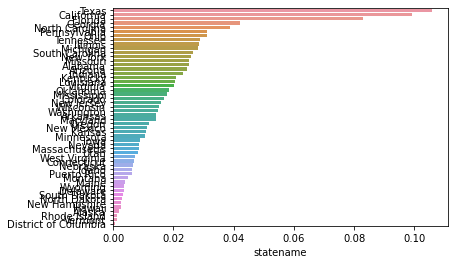

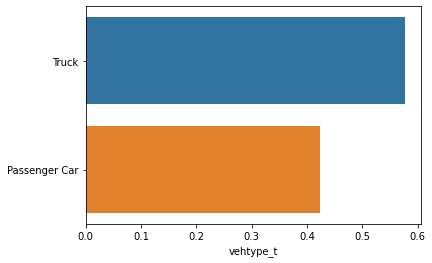

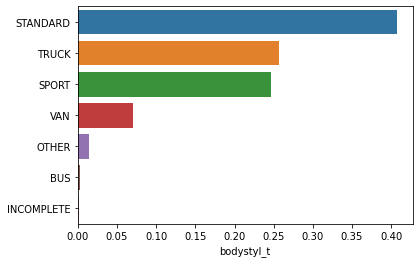

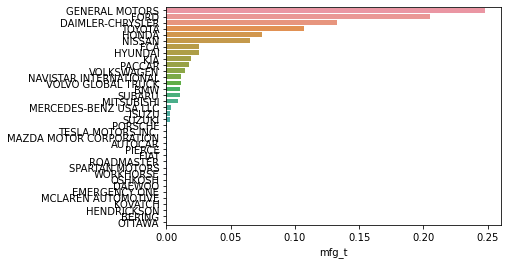

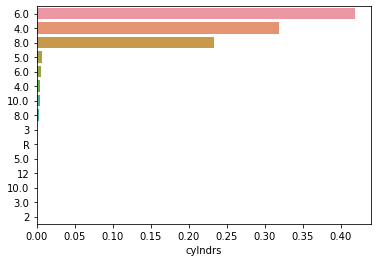

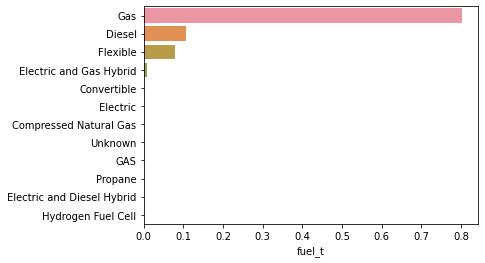

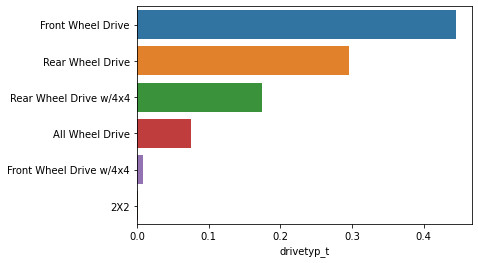

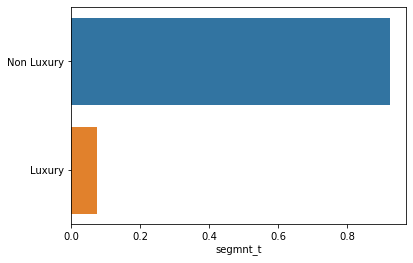

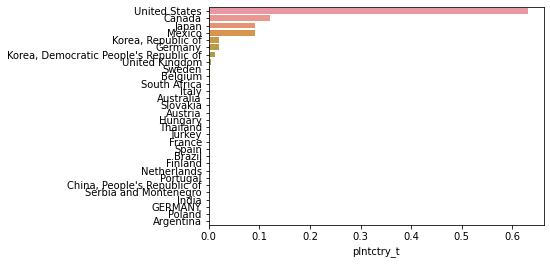

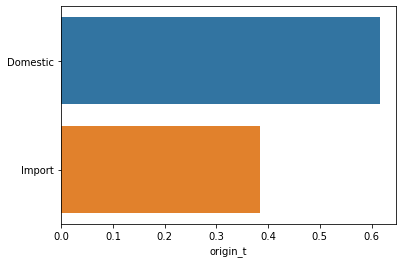

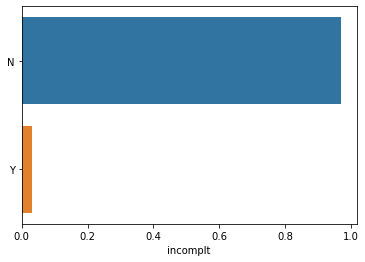

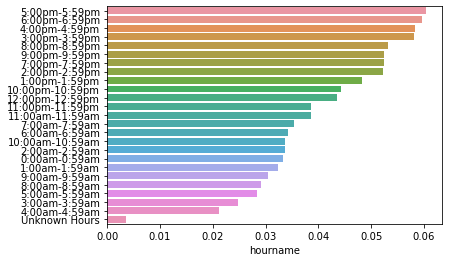

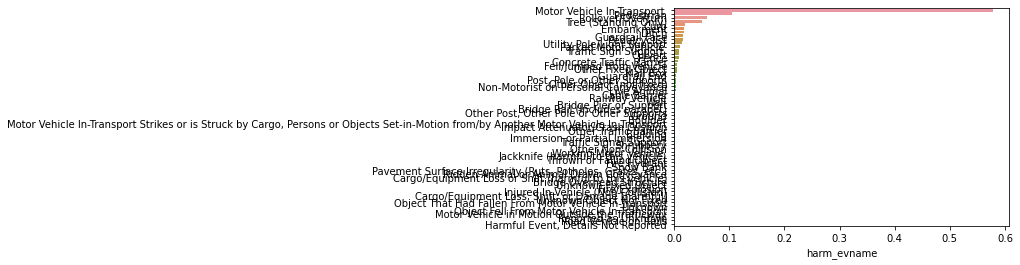

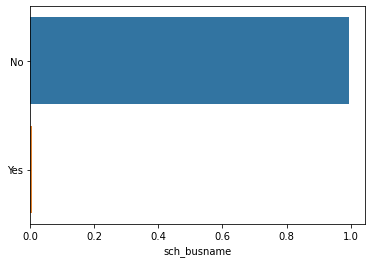

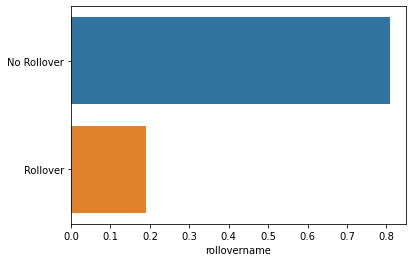

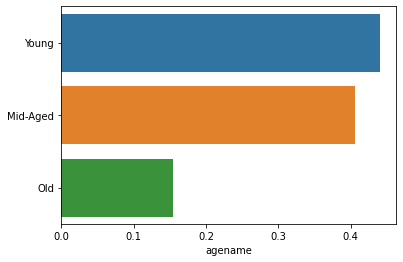

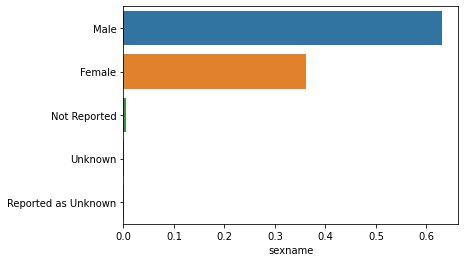

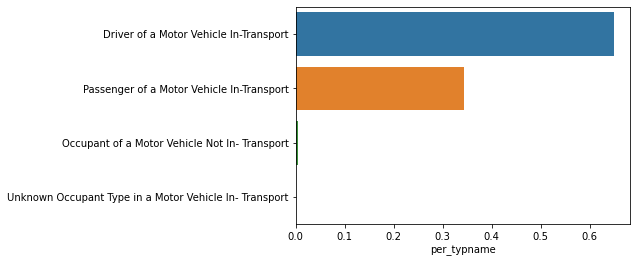

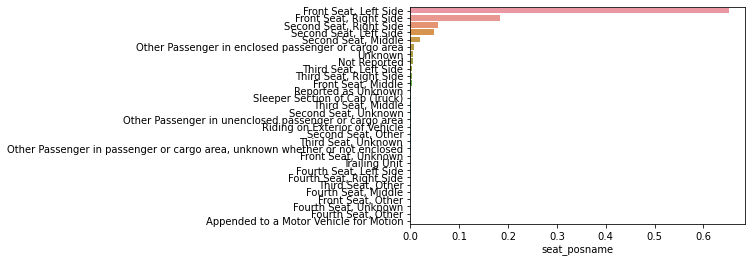

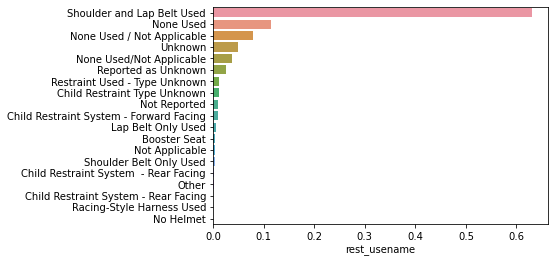

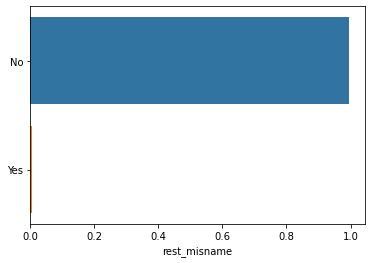

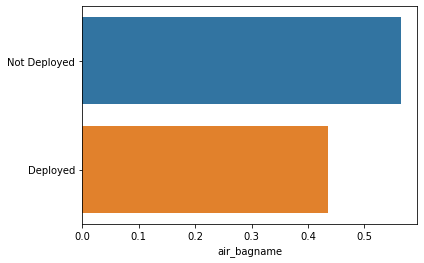

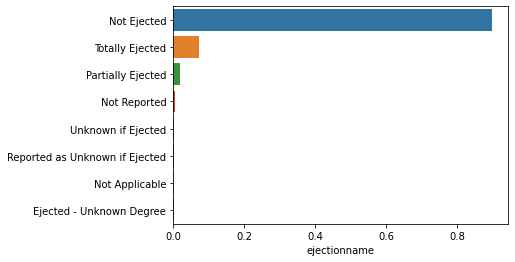

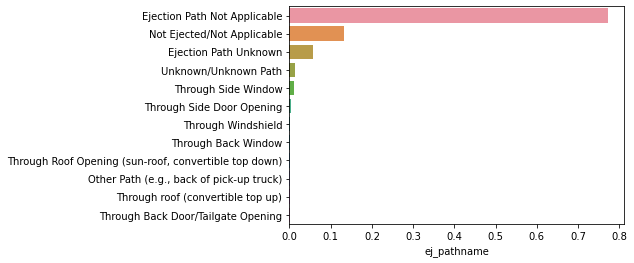

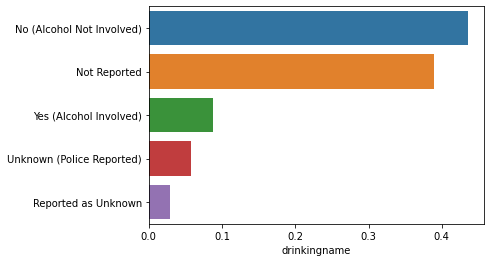

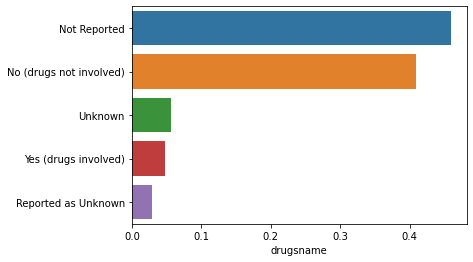

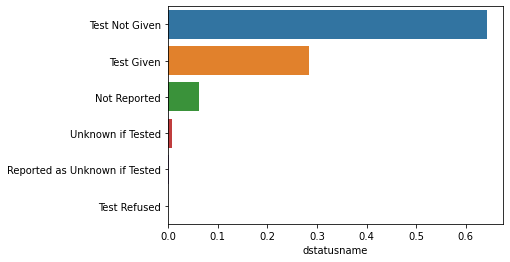

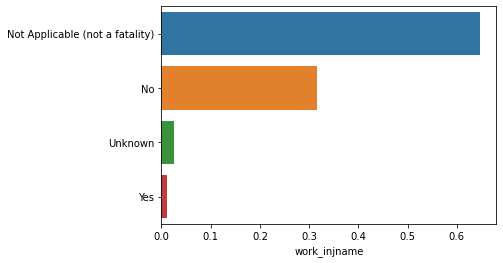

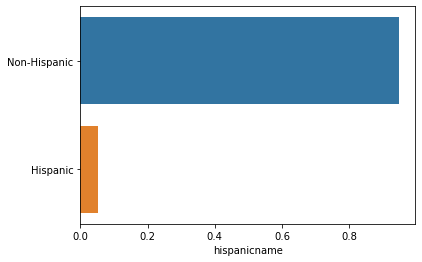

In [375]:
for feature in data.dtypes[data.dtypes == 'category'].index:
    value_percentages = data[feature].value_counts(normalize=True, sort=True)
    sns.barplot(x=value_percentages, y=value_percentages.index, orient='h', order=value_percentages.index)
    plt.show()

In [376]:
for column in categorical_columns:
    data[column] = data[column].astype('object')

<ipython-input-376-06093bef9bea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = data[column].astype('object')


# Encoding

# I tried pd.get_dummies() method for encoding but it increase column number which is cost me a high computational cost..

categorical_columns = data.select_dtypes("object")

In [69]:
#Label Encoder used for labeling different categorical(object) features with numeric values
encode = LabelEncoder()

for col in categorical_columns:
    data[col] = encode.fit_transform(data[col].astype(str))

<ipython-input-69-a10a3fb27e78>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = encode.fit_transform(data[col].astype(str))


In [70]:
data.shape

(394670, 43)

sns.barplot(data["rollovername"])
plt.show()

In [ ]:
for c in data.columns:
    print(c)
    print(data[c].unique())
    #col_len = len(print(data[c].unique()))
    print("")

In [ ]:
data.describe().round(1)

In [71]:
corr = data.corr(method="pearson")
corr_df = pd.DataFrame(corr)
corr_df

,caseyear,statename,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,incomplt,ve_forms,per_no,hourname,harm_evname,sch_busname,rollover,rollovername,agename,sexname,per_typname,inj_sevname,seat_posname,rest_usename,rest_misname,air_bagname,ejectionname,ej_pathname,drinkingname,drugsname,dstatusname,work_injname,hispanicname
caseyear,1.000000,-0.015164,0.229225,0.023812,-0.019518,0.028676,0.089140,0.072627,0.031426,-0.008230,-0.067977,-0.015058,0.024191,0.063279,-0.019189,-0.006187,-0.007824,0.041381,0.106011,0.094175,-0.011058,0.011236,-0.013529,0.000961,-0.002812,-0.002850,-0.008022,-0.035675,-0.016179,-0.001654,-0.017571,-0.022149,-0.025105,0.022377,0.027641,-0.060334,-0.025194,-0.352426,-0.048611,-0.027861,-0.107125,0.032722,-0.002282
statename,-0.015164,1.000000,-0.004667,0.036268,0.017551,-0.013947,0.011339,0.042229,-0.040052,0.041182,0.018361,-0.036989,0.012753,-0.011661,0.026698,0.035927,0.017265,-0.064499,-0.030135,-0.024690,0.010001,0.005227,0.003332,-0.006267,-0.003154,0.009619,0.028140,0.011957,0.001036,0.005649,-0.003824,-0.023949,-0.001221,-0.026815,0.004404,-0.032326,0.015811,0.015963,0.030308,0.025948,0.030104,0.023351,0.002851
vinyear,0.229225,-0.004667,1.000000,-0.001615,-0.047693,0.104026,0.360445,0.243503,0.082278,0.018267,-0.170439,-0.142265,0.057577,0.203997,-0.162902,0.010467,-0.061789,0.112746,0.456202,0.387231,-0.007424,0.102774,0.004141,-0.008108,-0.041543,0.018873,-0.107952,-0.153921,-0.032861,-0.056248,0.008963,0.071451,0.018280,0.139746,-0.001293,-0.151010,-0.137688,-0.161238,-0.100957,-0.080611,0.005244,0.140158,0.058955
vehtype_t,0.023812,0.036268,-0.001615,1.000000,0.101629,-0.198818,0.649295,0.700422,-0.158140,0.466098,0.473102,-0.301822,0.233000,0.074600,0.507560,0.172107,0.181608,-0.336769,-0.215165,-0.151520,0.152519,0.021059,0.069921,0.016656,0.011681,0.032822,0.076715,0.111376,-0.137085,0.087722,0.016494,0.072537,0.041233,-0.007239,-0.001130,0.160464,0.034047,0.016109,-0.061480,-0.059497,0.056028,0.154901,0.055112
bodystyl_t,-0.019518,0.017551,-0.047693,0.101629,1.000000,-0.203003,0.114150,0.017677,-0.024199,0.266539,0.150656,-0.250250,-0.034801,-0.199171,0.164469,0.124646,0.012249,-0.107460,-0.089426,-0.057917,0.004509,0.012034,-0.078967,0.002526,-0.012710,-0.158196,-0.022008,-0.040642,-0.079911,0.134225,-0.053562,-0.014973,-0.038210,0.023309,-0.004767,0.066734,-0.022929,-0.001305,-0.021297,-0.024656,0.005135,0.059104,0.009540
doors,0.028676,-0.013947,0.104026,-0.198818,-0.203003,1.000000,-0.236010,-0.143308,-0.065445,-0.671875,-0.099717,0.560579,0.581181,0.516977,-0.279459,-0.078537,-0.094887,0.164936,0.351794,0.318376,-0.345122,-0.022956,0.052173,0.008630,0.025138,-0.111126,-0.001775,-0.003902,0.130496,-0.186870,0.117939,0.025185,0.116104,-0.025044,0.017331,-0.215339,-0.005871,-0.019380,0.058020,0.046412,0.009066,-0.149382,-0.012576
wheels,0.089140,0.011339,0.360445,0.649295,0.114150,-0.236010,1.000000,0.833169,-0.044889,0.427442,0.187420,-0.340830,0.032567,-0.018728,0.324350,0.157500,0.111890,-0.155714,0.084111,0.020415,0.110238,0.055064,0.020211,0.007847,-0.005225,0.017578,0.017567,0.023883,-0.124824,0.061545,-0.016399,0.069150,0.006118,0.057084,-0.003128,0.088279,-0.025959,-0.047266,-0.090247,-0.080785,0.036040,0.183830,0.060648
drivwhls,0.072627,0.042229,0.243503,0.700422,0.017677,-0.143308,0.833169,1.000000,-0.073435,0.428229,0.305950,-0.323637,0.191818,0.136901,0.433858,0.096856,0.142520,-0.195807,-0.005103,-0.010790,0.050698,0.043743,0.007216,0.008225,0.000687,-0.005289,0.047587,0.065060,-0.111121,0.073996,-0.013529,0.066715,0.004587,0.029308,-0.001365,0.089002,0.006753,-0.016829,-0.065681,-0.073266,0.026957,0.155725,0.074117
mfg_t,0.031426,-0.040052,0.082278,-0.158140,-0.024199,-0.065445,-0.044889,-0.073435,1.000000,-0.040711,-0.272136,-0.021469,-0.252615,-0.156060,-0.239371,-0.019888,-0.065797,0.646302,0.189568,0.198207,0.006319,0.025591,-0.039003,-0.002954,-0.009976,0.000194

<AxesSubplot:>

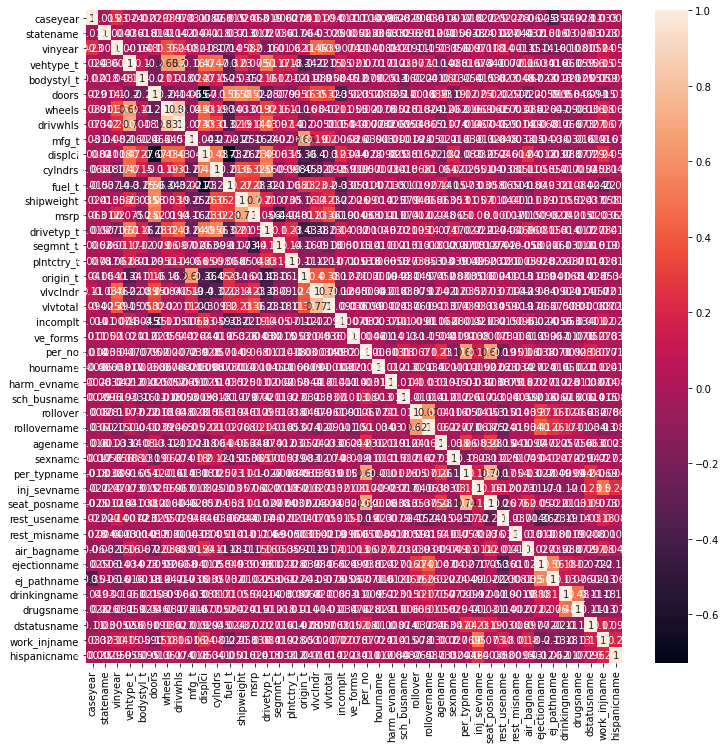

In [72]:
plt.figure(figsize=(12, 12))
sns.heatmap(corr_df, annot=True)

In [73]:
corr_df["rollovername"].sort_values(ascending=False).round(2)

rollovername    1.00
rollover        0.62
ejectionname    0.41
ej_pathname     0.26
drinkingname    0.17
drivetyp_t      0.14
vehtype_t       0.11
drugsname       0.11
cylndrs         0.10
per_no          0.10
seat_posname    0.07
per_typname     0.07
shipweight      0.07
drivwhls        0.07
agename         0.06
plntctry_t      0.05
air_bagname     0.03
harm_evname     0.03
fuel_t          0.03
sexname         0.03
wheels          0.02
displci         0.02
msrp            0.02
segmnt_t        0.02
rest_misname    0.01
statename       0.01
doors          -0.00
incomplt       -0.01
sch_busname    -0.01
dstatusname    -0.03
hourname       -0.03
caseyear       -0.04
bodystyl_t     -0.04
mfg_t          -0.05
inj_sevname    -0.06
origin_t       -0.07
hispanicname   -0.09
vlvtotal       -0.09
vlvclndr       -0.12
work_injname   -0.13
ve_forms       -0.15
vinyear        -0.15
rest_usename   -0.24
Name: rollovername, dtype: float64

#  Part-4: Data Splitting and Transformation
> Firstly, split your data into training and test datasets before the data transformation. <br>
Then, scale numerical features and encode categorical features based on the training dataset.

To split the dataset, which of the following strategies is better?:

(1) Using accidents in 2019 for testing. <br>
(2) Getting random 30% of data for testing.

Which choice you selected will not matter for grading, but, how you choose it matters for the learning task. Think about which testing approach is more reasonable/meaningful regarding to create a business value. 

**Note:** If you have included year as a feature and you select (1), you should scale it properly for testing dataset. <br>

In [83]:
data.drop("rollover", axis=1, inplace=True)

C:\Users\MONSTER\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [84]:
x = data.drop("rollovername", axis=1, inplace=False) #related features
y = data["rollovername"] #target

In [85]:
x

,caseyear,statename,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,incomplt,ve_forms,per_no,hourname,harm_evname,sch_busname,agename,sexname,per_typname,inj_sevname,seat_posname,rest_usename,rest_misname,air_bagname,ejectionname,ej_pathname,drinkingname,drugsname,dstatusname,work_injname,hispanicname
0,2014,0,2011.0,0,4,4.0,4.0,2.0,32,110.0,7,8,2734.0,15600.0,2,1,5,4,4.0,16.0,0,1,1,6,0,0,3,1,0,1,6,17,0,0,2,2,4,3,2,0,1
1,2014,0,2011.0,0,4,4.0,4.0,2.0,32,110.0,7,8,2734.0,15600.0,2,1,5,4,4.0,16.0,0,1,2,6,0,0,3,0,2,6,9,17,0,0,2,2,1,1,3,1,1
2,2014,0,1997.0,1,5,2.0,4.0,2.0,4,360.0,13,8,4787.0,20775.0,4,1,17,0,2.0,16.0,0,1,1,7,53,0,1,1,0,1,6,7,0,0,2,2,4,0,2,0,1
3,2014,0,2004.0,0,4,4.0,0.0,0.0,9,214.0,11,8,3315.0,23495.0,2,1,29,0,0.0,0.0,0,2,1,10,27,0,3,1,0,6,6,7,0,1,2,2,3,3,3,1,1
4,2014,0,2004.0,0,4,4.0,0.0,0.0,9,214.0,11,8,3315.0,23495.0,2,1,29,0,0.0,0.0,0,2,2,10,27,0,3,0,2,3,9,17,0,0,2,2,1,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452905,2019,51,2010.0,1,3,4.0,4.0,4.0,12,212.0,10,8,4120.0,30295.0,1,1,29,4,4.0,24.0,0,1,1,12,12,0,3,1,0,1,6,9,0,0,6,1,4,4,2,0,1
452906,2019,51,2010.0,1,3,4.0,4.0,4.0,12,212.0,10,8,4120.0,30295.0,1,1,29,4,4.0,24.0,0,1,2,12,12,0,3,1,2,5,9,9,0,0,2,0,1,1,3,1,1
452907,2019,51,2013.0,0,4,4.0,4.0,2.0,4,122.0,6,8,3186.0,17995.0,2,1,29,0,4.0,16.0,0,2,1,4,27,0,1,1,0,1,6,17,0,0,2,0,4,0,0,0,1
452908,2019,51,2013.0,0,4,4.0,4.0,2.0,4,122.0,6,8,3186.0,17995.0,2,1,29,0,4.0,16.0,0,2,2,4,27,0,1,0,2,1,9,17,0,0,2,0,1,1,0,0,1


In [86]:
y

0         1
1         1
2         0
3         0
4         0
         ..
452905    1
452906    1
452907    0
452908    0
452909    0
Name: rollovername, Length: 394670, dtype: int32

In [87]:
y = pd.DataFrame(y)

Splitting and Training

In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [89]:
x_train

,caseyear,statename,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,incomplt,ve_forms,per_no,hourname,harm_evname,sch_busname,agename,sexname,per_typname,inj_sevname,seat_posname,rest_usename,rest_misname,air_bagname,ejectionname,ej_pathname,drinkingname,drugsname,dstatusname,work_injname,hispanicname
290941,2017,44,2012.0,1,5,4.0,4.0,2.0,4,348.0,12,8,4890.0,25600.0,4,1,29,0,2.0,16.0,0,2,1,11,27,0,3,1,0,3,6,17,0,1,2,0,1,1,3,1,1
402504,2019,11,2015.0,0,4,4.0,4.0,2.0,32,110.0,6,8,2855.0,16900.0,2,1,29,4,4.0,16.0,0,1,3,10,14,0,1,1,2,1,17,9,0,0,2,0,4,4,2,0,0
83177,2015,9,2012.0,0,4,4.0,4.0,2.0,4,220.0,10,6,3961.0,25495.0,4,1,5,0,4.0,24.0,0,1,1,16,41,0,3,0,0,3,6,17,0,1,2,0,0,1,3,1,1
239220,2017,9,2006.0,1,5,4.0,4.0,4.0,9,403.0,12,2,5907.0,32185.0,5,1,29,0,0.0,0.0,0,2,1,7,27,0,2,1,0,3,6,17,0,0,2,0,0,0,3,1,1
371123,2018,44,2018.0,0,4,2.0,4.0,2.0,6,220.0,10,6,3894.0,26995.0,4,1,5,0,4.0,24.0,0,1,1,13,40,0,3,0,0,3,6,17,0,1,2,0,1,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297771,2017,48,2002.0,1,5,4.0,4.0,4.0,4,287.0,12,8,5000.0,25350.0,5,1,29,0,2.0,0.0,0,1,2,8,47,0,3,1,2,4,9,17,0,1,2,0,1,1,2,1,1
420000,2019,27,2012.0,0,6,3.0,4.0,2.0,2,98.0,6,8,2833.0,24900.0,2,1,28,3,4.0,16.0,0,5,1,3,27,0,1,1,0,3,6,17,0,1,2,0,4,0,3,1,1
151973,2016,4,2015.0,1,5,4.0,4.0,4.0,9,262.0,10,8,5216.0,37730.0,5,1,29,0,4.0,24.0,0,3,2,3,27,0,3,0,2,3,9,17,0,1,2,0,1,1,3,1,1
169422,2016,12,2014.0,1,3,4.0,4.0,4.0,6,220.0,10,6,4521.0,33995.0,5,1,29,0,4.0,24.0,0,2,1,15,27,0,1,1,0,4,6,17,0,0,2,0,0,0,3,1,1


In [90]:
x_test

,caseyear,statename,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,incomplt,ve_forms,per_no,hourname,harm_evname,sch_busname,agename,sexname,per_typname,inj_sevname,seat_posname,rest_usename,rest_misname,air_bagname,ejectionname,ej_pathname,drinkingname,drugsname,dstatusname,work_injname,hispanicname
87187,2015,9,1998.0,1,5,3.0,4.0,4.0,8,281.0,12,8,4480.0,20710.0,5,1,29,0,0.0,0.0,0,1,2,0,36,0,3,1,2,1,9,7,0,0,2,0,1,1,0,0,1
428856,2019,35,2016.0,0,4,4.0,4.0,2.0,11,122.0,6,8,2742.0,18640.0,2,1,29,4,4.0,16.0,0,3,1,18,27,0,1,1,0,3,6,17,0,1,2,0,0,0,3,1,1
285189,2017,42,2009.0,0,4,4.0,4.0,2.0,32,110.0,6,8,2723.0,15250.0,2,1,29,4,4.0,16.0,0,2,1,1,27,0,3,1,0,1,6,17,0,0,2,0,0,0,2,0,1
206776,2016,43,2012.0,0,4,4.0,4.0,2.0,33,121.0,6,8,3882.0,16465.0,2,1,17,4,4.0,16.0,0,2,4,24,27,0,1,1,2,1,17,18,0,1,2,0,0,0,2,0,1
412556,2019,20,1994.0,1,3,2.0,4.0,4.0,4,150.0,6,8,2870.0,11390.0,5,1,29,0,0.0,0.0,0,2,2,0,27,0,3,1,2,7,9,9,0,1,2,0,1,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306146,2018,3,2004.0,1,5,4.0,4.0,4.0,8,330.0,12,8,6234.0,24495.0,5,1,29,0,2.0,16.0,0,3,1,17,27,0,1,1,0,3,6,17,0,0,2,0,2,2,2,1,1
450958,2019,49,1998.0,1,5,2.0,4.0,4.0,8,245.0,10,8,3597.0,17370.0,5,1,29,0,0.0,0.0,0,2,2,21,27,0,3,0,2,7,9,17,0,0,2,0,1,1,3,1,1
449156,2019,47,2010.0,1,3,4.0,4.0,4.0,11,213.0,10,8,4544.0,35445.0,1,1,29,4,4.0,24.0,0,1,2,18,11,0,3,1,2,1,20,9,0,0,6,1,1,1,3,0,1
319381,2018,9,2010.0,1,6,4.0,4.0,2.0,11,214.0,10,8,4574.0,33405.0,2,1,29,4,4.0,24.0,0,1,2,12,41,0,1,0,2,3,9,17,0,1,2,0,1,1,3,1,1


In [91]:
y_train

,rollovername
290941,0
402504,1
83177,0
239220,0
371123,0
...,...
297771,1
420000,0
151973,0
169422,0


In [377]:
y_test

,rollovername
87187,0
428856,0
285189,0
206776,0
412556,0
...,...
306146,0
450958,0
449156,1
319381,0


# Encoding

In [93]:
categorical_columns = data.select_dtypes("object")

In [94]:
#Label Encoder used for labeling different categorical(object) features with numeric values
encode = LabelEncoder()

for col in categorical_columns:
    data[col] = encode.fit_transform(data[col].astype(str))

In [95]:
data.shape

(394670, 42)

#  Part-5: Feature Selection

> You are required to present **at most 30** useful features at the end of the project.<br>
> It is not required to have 30 features before training. You should eliminate some features before and after the data learning phase to report at the end. <br>
> So, you need to select one or multiple feature subsets to experiment ML models.<br>
> It is worthy to note that you are not encouraged to be minimalistic (like using 5 features) while the selection because it might sacrifice some learning performance. But maybe only 5 features can be useful, it is unknown for now and it will turn out with your selection approach.

You can either select features manually and/or in an automated way.
If you deploy an automated feature selection method, you **must explain how it works** in the report.

Some manual ways: Thresholding correlations, multicollinearity inspection, considering value distributions with respect to the target variable, finding non-informative features, ...

Some automated ways: 
- selecting the best k variables based on a statistical score 
- forward/backward/recursive feature elimination
- identifying important features using a decision-tree based model

## Selecting best k feature

In [96]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x_k = data.drop("rollovername", axis=1, inplace=False) #related features
y_k = data["rollovername"] #target  

kBest = SelectKBest(score_func=chi2, k=10)
fit = kBest.fit(x_k, y_k)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x_k.columns)


featureScores = pd.concat([df_columns,df_scores], axis=1)
featureScores.columns = ['Feature','Score'] 
featureScores.sort_values(by=["Score"], ascending=False)

print(featureScores.nlargest(30, 'Score'))

         Feature         Score
12    shipweight  1.121233e+06
13          msrp  1.024487e+06
35   ej_pathname  1.254099e+05
34  ejectionname  3.400591e+04
31  rest_usename  3.306821e+04
19      vlvtotal  2.990331e+04
9        displci  1.951395e+04
36  drinkingname  1.827926e+04
21      ve_forms  1.760109e+04
18      vlvclndr  8.605292e+03
8          mfg_t  6.262884e+03
30  seat_posname  5.807933e+03
37     drugsname  5.633513e+03
17      origin_t  4.902302e+03
14    drivetyp_t  4.482035e+03
16    plntctry_t  3.866898e+03
22        per_no  3.804084e+03
39  work_injname  2.826578e+03
10       cylndrs  2.636606e+03
28   per_typname  2.623820e+03
29   inj_sevname  2.183607e+03
3      vehtype_t  2.074168e+03
23      hourname  1.851720e+03
7       drivwhls  1.677639e+03
24   harm_evname  1.436703e+03
26       agename  6.441349e+02
1      statename  5.796253e+02
6         wheels  2.340190e+02
2        vinyear  2.125538e+02
33   air_bagname  1.960510e+02


# Logistic Regression with selected 30 feature 



In [97]:
x_topdown = ["shipweight","msrp","ej_pathname","agename","ejectionname","rest_usename","vlvtotal",
             "displci","drinkingname","ve_forms","vlvclndr","mfg_t","seat_posname","drugsname","origin_t",
             "drivetyp_t","plntctry_t","per_no","bodystyl_t","work_injname", "cylndrs","per_typname","inj_sevname",
             "vehtype_t","hourname","drivwhls","harm_evname","statename","wheels","vinyear"]

In [98]:
len(x_topdown)

30

In [99]:
x_new = data[x_topdown]

In [100]:
x_new

,shipweight,msrp,ej_pathname,agename,ejectionname,rest_usename,vlvtotal,displci,drinkingname,ve_forms,vlvclndr,mfg_t,seat_posname,drugsname,origin_t,drivetyp_t,plntctry_t,per_no,bodystyl_t,work_injname,cylndrs,per_typname,inj_sevname,vehtype_t,hourname,drivwhls,harm_evname,statename,wheels,vinyear
0,2734.0,15600.0,2,3,2,17,16.0,110.0,4,1,4.0,32,6,3,4,2,5,1,4,0,7,0,1,0,6,2.0,0,0,4.0,2011.0
1,2734.0,15600.0,2,3,2,17,16.0,110.0,1,1,4.0,32,9,1,4,2,5,2,4,1,7,2,6,0,6,2.0,0,0,4.0,2011.0
2,4787.0,20775.0,2,1,2,7,16.0,360.0,4,1,2.0,4,6,0,0,4,17,1,5,0,13,0,1,1,7,2.0,53,0,4.0,1997.0
3,3315.0,23495.0,2,3,2,7,0.0,214.0,3,2,0.0,9,6,3,0,2,29,1,4,1,11,0,6,0,10,0.0,27,0,0.0,2004.0
4,3315.0,23495.0,2,3,2,17,0.0,214.0,1,2,0.0,9,9,1,0,2,29,2,4,1,11,2,3,0,10,0.0,27,0,0.0,2004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452905,4120.0,30295.0,1,3,6,9,24.0,212.0,4,1,4.0,12,6,4,4,1,29,1,3,0,10,0,1,1,12,4.0,12,51,4.0,2010.0
452906,4120.0,30295.0,0,3,2,9,24.0,212.0,1,1,4.0,12,9,1,4,1,29,2,3,1,10,2,5,1,12,4.0,12,51,4.0,2010.0
452907,3186.0,17995.0,0,1,2,17,16.0,122.0,4,2,4.0,4,6,0,0,2,29,1,4,0,6,0,1,0,4,2.0,27,51,4.0,2013.0
452908,3186.0,17995.0,0,1,2,17,16.0,122.0,1,2,4.0,4,9,1,0,2,29,2,4,0,6,2,1,0,4,2.0,27,51,4.0,2013.0


Linear Regression for k best feature

In [101]:
x_train_k, x_test_k, y_train_k, y_test_k = train_test_split(x_new, y, test_size=0.3)

scale_k = StandardScaler()

x_train_k_std = scale_k.fit_transform(x_train_k)

x_test_k_std = scale_k.transform(x_test_k)

lr_k = LogisticRegression()

lr_k.fit(x_train_k_std, y_train_k)

pred_y_train_k = lr_k.predict(x_train_k_std)
pred_y_test_k = lr_k.predict(x_test_k_std)

lr_k_probabilities = lr_k.predict_proba(x_train_k_std)
lr_k_probabilities

lr_k.score(x_test_k_std, y_test_k)

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8525012457665053

<ipython-input-102-3d460efaf0fb>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train.values)


Feature: caseyear  Score: 0.02810
Feature: statename  Score: 0.04645
Feature: vinyear  Score: 0.04693
Feature: vehtype_t  Score: 0.00647
Feature: bodystyl_t  Score: 0.01130
Feature: doors  Score: 0.00704
Feature: wheels  Score: 0.00397
Feature: drivwhls  Score: 0.00830
Feature: mfg_t  Score: 0.02199
Feature: displci  Score: 0.03786
Feature: cylndrs  Score: 0.01288
Feature: fuel_t  Score: 0.00598
Feature: shipweight  Score: 0.04877
Feature: msrp  Score: 0.05090
Feature: drivetyp_t  Score: 0.01308
Feature: segmnt_t  Score: 0.00246
Feature: plntctry_t  Score: 0.01313
Feature: origin_t  Score: 0.00756
Feature: vlvclndr  Score: 0.00929
Feature: vlvtotal  Score: 0.01144
Feature: incomplt  Score: 0.00157
Feature: ve_forms  Score: 0.07455
Feature: per_no  Score: 0.01204
Feature: hourname  Score: 0.04655
Feature: harm_evname  Score: 0.15974
Feature: sch_busname  Score: 0.00041
Feature: agename  Score: 0.01480
Feature: sexname  Score: 0.00938
Feature: per_typname  Score: 0.00603
Feature: inj_sev

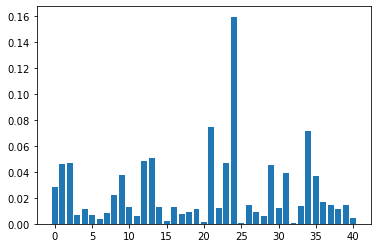

In [102]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(x_train, y_train.values)

importance = rfc.feature_importances_

for i,v in enumerate(importance):
    print('Feature:',x_train.columns[i] ,' Score: %.5f' % (v))
    
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [103]:
importance=np.array(importance)

In [104]:
importance_map={}

for i in range(len(importance)):
    key=x_train.columns[i]
    value=importance[i]
    importance_map[key]=value

importance_map

{'caseyear': 0.028096045794509045,
 'statename': 0.04645419698778659,
 'vinyear': 0.04692606762763511,
 'vehtype_t': 0.006468255440117066,
 'bodystyl_t': 0.011295385817189372,
 'doors': 0.007042340349214702,
 'wheels': 0.003974453913925421,
 'drivwhls': 0.008302690486392199,
 'mfg_t': 0.021990199606483612,
 'displci': 0.03786317514798581,
 'cylndrs': 0.012880103843979853,
 'fuel_t': 0.005976724163252543,
 'shipweight': 0.04877433609586541,
 'msrp': 0.05090167647293723,
 'drivetyp_t': 0.013075330881825767,
 'segmnt_t': 0.002464517216732673,
 'plntctry_t': 0.01313029152453781,
 'origin_t': 0.00755644348096151,
 'vlvclndr': 0.009289972638981583,
 'vlvtotal': 0.011439888924785492,
 'incomplt': 0.0015735815128035719,
 've_forms': 0.07455305190316495,
 'per_no': 0.012037595763005936,
 'hourname': 0.046550198668497855,
 'harm_evname': 0.15973909958219026,
 'sch_busname': 0.00040888508421646177,
 'agename': 0.01479553878427408,
 'sexname': 0.009379474926975953,
 'per_typname': 0.00602987018520

In [105]:
import operator
sorted_importance = dict(sorted(importance_map.items(),
                            key=operator.itemgetter(1),
                            reverse=True))
sorted_importance

{'harm_evname': 0.15973909958219026,
 've_forms': 0.07455305190316495,
 'ejectionname': 0.07193593065035106,
 'msrp': 0.05090167647293723,
 'shipweight': 0.04877433609586541,
 'vinyear': 0.04692606762763511,
 'hourname': 0.046550198668497855,
 'statename': 0.04645419698778659,
 'inj_sevname': 0.04563910557285743,
 'rest_usename': 0.03885392460633203,
 'displci': 0.03786317514798581,
 'ej_pathname': 0.03659570905495234,
 'caseyear': 0.028096045794509045,
 'mfg_t': 0.021990199606483612,
 'drinkingname': 0.01661418680962918,
 'agename': 0.01479553878427408,
 'drugsname': 0.014267032281560121,
 'work_injname': 0.014245926023019002,
 'air_bagname': 0.013959074497948193,
 'plntctry_t': 0.01313029152453781,
 'drivetyp_t': 0.013075330881825767,
 'cylndrs': 0.012880103843979853,
 'seat_posname': 0.012273812482557205,
 'per_no': 0.012037595763005936,
 'dstatusname': 0.011724460229784853,
 'vlvtotal': 0.011439888924785492,
 'bodystyl_t': 0.011295385817189372,
 'sexname': 0.009379474926975953,
 'v

In [106]:
sorted(importance_map.keys())

['agename',
 'air_bagname',
 'bodystyl_t',
 'caseyear',
 'cylndrs',
 'displci',
 'doors',
 'drinkingname',
 'drivetyp_t',
 'drivwhls',
 'drugsname',
 'dstatusname',
 'ej_pathname',
 'ejectionname',
 'fuel_t',
 'harm_evname',
 'hispanicname',
 'hourname',
 'incomplt',
 'inj_sevname',
 'mfg_t',
 'msrp',
 'origin_t',
 'per_no',
 'per_typname',
 'plntctry_t',
 'rest_misname',
 'rest_usename',
 'sch_busname',
 'seat_posname',
 'segmnt_t',
 'sexname',
 'shipweight',
 'statename',
 've_forms',
 'vehtype_t',
 'vinyear',
 'vlvclndr',
 'vlvtotal',
 'wheels',
 'work_injname']

In [107]:
x_rfc = ['agename','air_bagname','bodystyl_t','caseyear','cylndrs','displci','doors','drinkingname','drivetyp_t','drivwhls',
         'drugsname','dstatusname','ej_pathname','ejectionname','fuel_t','harm_evname','hispanicname','hourname','incomplt',
         'inj_sevname','mfg_t','msrp','origin_t','per_no','per_typname','plntctry_t','rest_misname','rest_usename','sch_busname',
         'seat_posname','segmnt_t','sexname','shipweight','statename','ve_forms','vehtype_t','vinyear','vlvclndr','vlvtotal',
         'wheels','work_injname']

In [108]:
len(x_rfc)

41

In [109]:
x_train_rfc, x_test_rfc, y_train_rfc, y_test_rfc = train_test_split(data[x_rfc], y, test_size=0.3)

scale_rfc = StandardScaler()

x_train_rfc_std = scale_rfc.fit_transform(x_train_rfc)

x_test_rfc_std = scale_rfc.transform(x_test_rfc)

lr_rfc = LogisticRegression()

lr_rfc.fit(x_train_rfc_std, y_train_rfc)

#pred_y_train_rfc = lr_rfc.predict(x_train_rfc_std)
pred_y_test_rfc = lr_rfc.predict(x_test_rfc_std)

#lr_rfc_probabilities = lr_rfc.predict_proba(x_train_rfc_std)

lr_rfc.score(x_test_rfc_std, y_test_rfc)

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.853565425967686

## RFE feature elimination

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

x_rfe = data.drop("rollovername", axis=1, inplace=False) #related features 
y_rfe = data["rollovername"] #target

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

decTreeModel = DecisionTreeClassifier()

pipeline = Pipeline(steps=[('s',rfe),('m',decTreeModel)])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

n_scores = cross_val_score(pipeline, x_rfe, y_rfe, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print(n_scores)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

## Decision Tree based model

In [ ]:
data.to_csv(r'C:\Users\MONSTER\CS452\farsSVM.csv', index = False)

#  Part-6: Training and Performance Evaluation

> You need to determine a score which is proper for the learning task and the distribution of target variable to benchmark the models. Note that even a model is successful for a target metric, it might performs poorly in terms of other performance scores. So, you should observe multiple metrics. <br>
> **Hint:** Think about which type of error made in predictions is more harmful from a car insurance business perspective: False negative  or false positive predictions? <br>

> According EDA done in the previous parts, you might need to adress any imbalanced dataset problem. (Not expected to use advanced methods or to do an extensive experimentation) <br>
**Hint**: Inspect model parameters which are related to class weightening or loss weightening.

> You have three Naive-Bayes-based model options for benchmarking with other types of models: ```GaussianNB```, ```CategoricalNB```, and ```ComplementNB```.
Read the descriptions provided in Sklearn library or search them on the Internet, and choose one of them regarding which sounds more reasonable considering the dataset characteristics and the learning task.<br>
**BONUS**: Experiment a simple prediction technique ensembling multiple Naive-Bayes models. (not required)

In [ ]:
#YOUR CODE HERE

> Plot training and testing performance of all models with a bar chart.

In [ ]:
#YOUR CODE HERE

## Logistic Regression

In [110]:
# x and y for Logistic Regression (lr)

x_train_lr = x_train.copy()
y_train_lr = y_train.copy()

x_test_lr = x_test.copy()
y_test_lr = y_test.copy()

In [111]:
scale_lr = StandardScaler()

x_train_lr_std = scale_lr.fit_transform(x_train_lr)

x_test_lr_std = scale_lr.transform(x_test_lr)

In [112]:
x_train_lr_std.shape

(276269, 41)

In [113]:
x_test_lr_std.shape

(118401, 41)

In [114]:
y_train_lr.shape

(276269, 1)

In [115]:
y_test_lr.shape

(118401, 1)

In [116]:
lr = LogisticRegression()

lr.fit(x_train_lr_std, y_train_lr)

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [134]:
pred_y_train_lr = lr.predict(x_train_lr_std)
pred_y_test_lr = lr.predict(x_test_lr_std)

lr_probabilities = lr.predict_proba(x_train_lr_std)
lr_probabilities

print("Logistic Regression score:",lr.score(x_test_lr_std, y_test_lr))

Logistic Regression score: 0.8515384160606752


In [425]:
lr_score = lr.score(x_test_lr_std, y_test_lr)

In [118]:
print("              Train Classification Report ")
print(classification_report(y_train_lr, pred_y_train_lr))

              Train Classification Report 
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    223664
           1       0.74      0.35      0.48     52605

    accuracy                           0.85    276269
   macro avg       0.80      0.66      0.70    276269
weighted avg       0.84      0.85      0.83    276269



In [119]:
print("              Test Classification Report ")
print(classification_report(y_test_lr, pred_y_test_lr))

              Test Classification Report 
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     95597
           1       0.74      0.35      0.48     22804

    accuracy                           0.85    118401
   macro avg       0.80      0.66      0.70    118401
weighted avg       0.84      0.85      0.83    118401



In [120]:
LR_CM = confusion_matrix(y_train_lr, pred_y_train_lr)

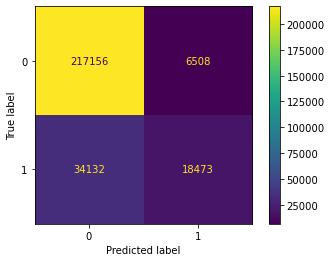

In [121]:
LR_CM_Disp = ConfusionMatrixDisplay(confusion_matrix=LR_CM)
LR_CM_Disp.plot()

In [122]:
print("Accuracy",accuracy_score(y_test, lr.predict(x_test_lr_std)))
print("Precision", precision_score(y_test, lr.predict(x_test_lr_std), average='micro'))
print("Recall", recall_score(y_test, lr.predict(x_test_lr_std), average='micro'))
print("F1", f1_score(y_test, lr.predict(x_test_lr_std), average='micro'))

Accuracy 0.8515384160606752
Precision 0.8515384160606752
Recall 0.8515384160606752
F1 0.8515384160606752


## Decision Tree

In [385]:
# x and y for Decision Tre (dt)
x_train_dt = x_train.copy()
y_train_dt = y_train.copy()
x_test_dt = x_test.copy()
y_test_dt = y_test.copy()

In [386]:
from sklearn.tree import DecisionTreeClassifier
mytree=DecisionTreeClassifier(criterion="entropy", max_depth=4)
mytree.fit(x_train_dt,y_train_dt) #we do not need to scale the data

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [387]:
mytree.predict(x_test_dt)

array([0, 0, 0, ..., 1, 0, 0])

In [388]:
mytree.score(x_test_dt, y_test_dt)

0.8608795533821505

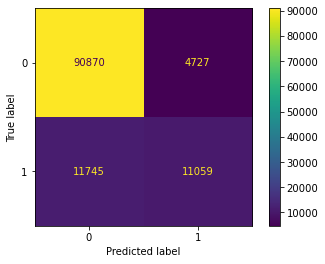

In [389]:
RD_CM=confusion_matrix(y_test_dt, mytree.predict(x_test_dt))
RD_CM_Disp=ConfusionMatrixDisplay(confusion_matrix=RD_CM)
RD_CM_Disp.plot()

In [390]:
from sklearn.tree import export_graphviz
export_graphviz(mytree, out_file="dectreehw2.dot",feature_names = x.columns)

## Random Forests

In [391]:
# x and y for Random Forests (rf)
x_train_rf = x_train.copy()
y_train_rf = y_train.copy()
x_test_rf = x_test.copy()
y_test_rf = y_test.copy()

rf = RandomForestClas(x_train_rf, y_train_rf)

rf.fit(x_train_rf, y_train_rf)

importance = rf.feature_importances_

for i,v in enumerate(importance):
    print('Feature:',x_train_rf.columns[i] ,' Score: %.5f' % (v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [392]:
scale_rf = StandardScaler()

x_test_rf_std = scale_rf.fit_transform(x_test_rf)
x_train_rf_std = scale_rf.transform(x_train_rf)

In [393]:
rf = RandomForestClassifier(criterion="entropy", n_estimators=100, max_depth=4, random_state=0)

In [394]:
rf.fit(x_train_rf_std, y_train_rf)

<ipython-input-394-0797612300fa>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_rf_std, y_train_rf)


RandomForestClassifier(criterion='entropy', max_depth=4, random_state=0)

In [395]:
print("Random Forests score:",rf.score(x_test_rf, y_test_rf))

Random Forests score: 0.8074002753355124


In [437]:
rf_score = rf.score(x_test_rf, y_test_rf)

In [396]:
rf.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0])

In [397]:
importance=rf.feature_importances_
importance

array([6.21191580e-03, 7.39506030e-05, 2.88257897e-02, 1.54722940e-02,
       4.58880803e-03, 1.37908711e-04, 4.52861660e-03, 2.77417269e-03,
       2.34442531e-04, 9.66673159e-03, 2.16231407e-03, 5.19687805e-04,
       4.03261394e-03, 1.36546289e-03, 1.51599085e-02, 4.12094803e-05,
       1.16975093e-04, 6.92260516e-04, 5.46839635e-03, 3.57458416e-03,
       0.00000000e+00, 2.25065146e-01, 8.35156937e-03, 8.84272969e-05,
       1.54427669e-01, 0.00000000e+00, 1.17043586e-03, 6.05805997e-05,
       4.08103926e-03, 6.94059346e-02, 7.59969720e-03, 6.80788190e-02,
       0.00000000e+00, 5.67877259e-03, 2.19655854e-01, 7.38930485e-02,
       1.56539075e-02, 1.45625383e-03, 2.21609802e-03, 3.66156827e-02,
       8.53021348e-04])

In [398]:
print(classification_report(y_test_rf,rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89     95597
           1       0.00      0.00      0.00     22804

    accuracy                           0.81    118401
   macro avg       0.40      0.50      0.45    118401
weighted avg       0.65      0.81      0.72    118401



C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [399]:
RF_CM= confusion_matrix(y_test_rf,rf.predict(x_test))

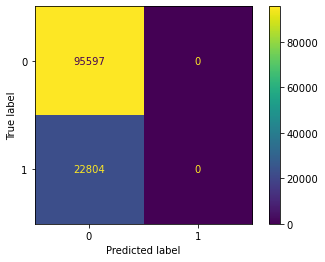

In [400]:
RF_CM_Disp=ConfusionMatrixDisplay(confusion_matrix=RF_CM)
RF_CM_Disp.plot()

In [424]:
from sklearn.tree import export_graphviz

export_graphviz(rf, out_file="randomforesthw2.dot", feature_names = x.columns)

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

## SVM

In [ ]:
# x and y for Support Vector Machine (svm)

x_train_svm = x_train.copy()
y_train_svm = y_train.copy()

x_test_svm = x_test.copy()
y_test_svm = y_test.copy()

In [ ]:
scale_svm = StandardScaler()


x_train_svm_std = scale_svm.fit_transform(x_train_svm)
x_test_svm_std=scale_svm.transform(x_test_svm)


svm_model = SVC(kernel="linear", C=0.1)

svm_model.fit(x_train_svm_std, y_train_svm)

In [ ]:
svm_model.predict(x_test_svm_std)

In [431]:
svc_score = 0.6491414768456347

In [ ]:
classification_report(y_test_svm, svm_model.predict(x_test_svm_std))

In [ ]:
SVM_CM=confusion_matrix(y_test, svm_model.predict(x_test_std))
SVM_CM_Disp=ConfusionMatrixDisplay(confusion_matrix=SVM_CM, display_labels=iris.target_names)
SVM_CM_Disp.plot()

## Naive Bayes

https://towardsdatascience.com/why-how-to-use-the-naive-bayes-algorithms-in-a-regulated-industry-with-sklearn-python-code-dbd8304ab2cf

## Naive Bayes: GaussianNB

In [148]:
# x and y for Gaussian Naive Bayes (gnb)
x_train_gnb = x_train.copy()
y_train_gnb = y_train.copy()
x_test_gnb = x_test.copy()
y_test_gnb = y_test.copy()

In [149]:
scale_gnb = MinMaxScaler()

x_train_gnb_std = scale_gnb.fit_transform(x_train_gnb)

x_test_gnb_std = scale_gnb.transform(x_test_gnb)

In [150]:
GausNB=GaussianNB()

#GausNB.predict_proba(two_obs_test[continuous_list])

In [151]:
GausNB.fit(x_train_gnb, y_train_gnb)

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB()

In [152]:
GausNB.predict(x_test_gnb_std)

array([0, 0, 0, ..., 0, 0, 0])

In [172]:
print("GaussianNB score:",GausNB.score(x_test_gnb_std, y_test_gnb))

GaussianNB score: 0.8074002753355124


In [432]:
gnb_score = GausNB.score(x_test_gnb_std, y_test_gnb)

In [457]:
print(classification_report(y_train_gnb, GausNB.predict(y_train_gnb)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89    223664
           1       0.00      0.00      0.00     52605

    accuracy                           0.81    276269
   macro avg       0.40      0.50      0.45    276269
weighted avg       0.66      0.81      0.72    276269



C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


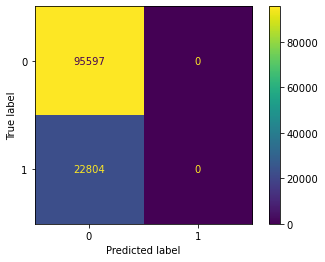

In [154]:
GausNB_CM = confusion_matrix(y_test_gnb, GausNB.predict(x_test_gnb_std))
GausNB_CM_Disp = ConfusionMatrixDisplay(confusion_matrix=GausNB_CM)
GausNB_CM_Disp.plot()

## Naive Bayes  CategoricalNB

In [155]:
# x and y for Categorical Naive Bayes (cat_nb)
x_train_cat = x_train.copy()
y_train_cat = y_train.copy()
x_test_cat = x_test.copy()
y_test_cat = y_test.copy()

In [156]:
scale_cat = MinMaxScaler()

x_train_cat_std = scale_cat.fit_transform(x_train_cat)

x_test_cat_std = scale_cat.transform(x_test_cat)

In [157]:
CategNB = CategoricalNB(alpha=1) #alpha=1

CategNB.fit(x_train_cat_std, y_train_cat)

#CategNB.predict_proba(two_obs_test[discret_list])

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


CategoricalNB(alpha=1)

In [462]:
CategNB.predict(x_train_cat_std, y_train_cat)

TypeError: predict() takes 2 positional arguments but 3 were given

In [170]:
print("CategoricalNB score:",CategNB.score(x_test_cat_std, y_test_cat))

CategoricalNB score: 0.8128816479590544


In [433]:
catnb_score = CategNB.score(x_test_cat_std, y_test_cat)

In [459]:
print(classification_report(y_train, CategNB.predict(y_train)))

ValueError: Expected input with 41 features, got 1 instead

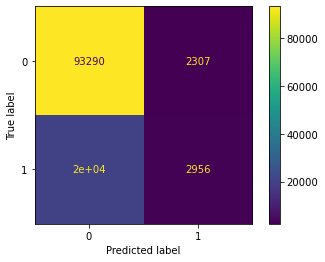

In [162]:
CategNB_CM=confusion_matrix(y_test_cat,CategNB.predict(x_test_cat_std))
CategNB_CM_Disp=ConfusionMatrixDisplay(confusion_matrix = CategNB_CM)
CategNB_CM_Disp.plot()

## Naive Bayes: ComplementNB

In [163]:
# x and y for Complement Naive Bayes (com)
x_train_com = x_train.copy()
y_train_com = y_train.copy()
x_test_com = x_test.copy()
y_test_com = y_test.copy()

In [164]:
scale_com = MinMaxScaler()

x_train_com_std = scale_com.fit_transform(x_train_com)

x_test_com_std = scale_com.transform(x_test_com)

In [165]:
ComplNB = ComplementNB(alpha=1, norm=False)

ComplNB.fit(x_train_com_std, y_train_com)

#ComplNB.predict_proba(two_obs_test[discret_list])

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


ComplementNB(alpha=1)

In [169]:
print("ComplementNB score:",ComplNB.score(x_test_com_std, y_test_com))

ComplementNB score: 0.710086908049763


In [434]:
comnb_score = ComplNB.score(x_test_com_std, y_test_com)

In [461]:
print(classification_report(y_train, ComplNB.predict(y_train)))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 41 is different from 1)

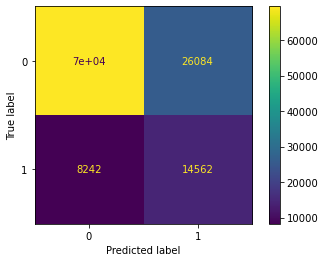

In [168]:
ComplNB_CM=confusion_matrix(y_test_com,ComplNB.predict(x_test_com_std))
ComplNB_CM_Disp=ConfusionMatrixDisplay(confusion_matrix = ComplNB_CM)
ComplNB_CM_Disp.plot()

# Part-7: Interpretation
7.1) Visualize rollover risk distributions of the models for training and testing datasets separately. Report the visual results.<br>
**Hint**: Use ```predict_proba``` function of the fitted models.

In [463]:
acc_scores_test = [svc_score, gnb_score, comnb_score,catnb_score ,lr_score, rf_score]
acc_scores_test

[0.6491414768456347,
 0.8074002753355124,
 0.710086908049763,
 0.8128816479590544,
 0.8515384160606752,
 0.8074002753355124]

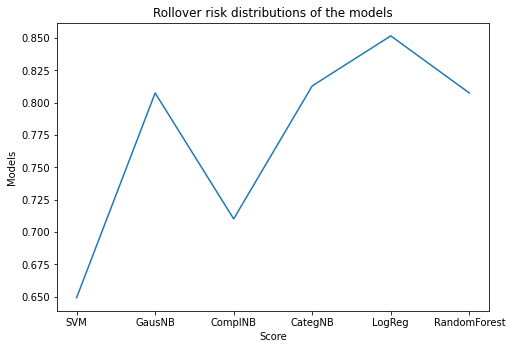

In [464]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['SVM', 'GausNB', 'ComplNB', 'CategNB','LogReg', 'RandomForest']

plt.xlabel("Score")
plt.ylabel("Models")
plt.title("Rollover risk distributions of the models")
ax.plot(models, acc_scores_test)
plt.show()

In [ ]:
predict_proba

## Logistic Regression Visualization

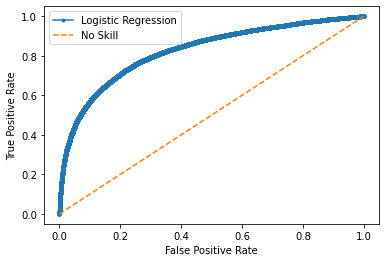

In [421]:
from sklearn.metrics import roc_auc_score, roc_curve

lr_probabilities = lr.predict_proba(x_test_lr_std)

lr_probabilities_positive = lr_probabilities[:,1]

lr_auc = roc_auc_score(y_test,lr_probabilities_positive)

ns_probilities = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test_lr, ns_probilities)
lr_fpr, lr_tpr, lr_thresholds=roc_curve(y_test_lr, lr_probabilities_positive)
ns_fpr, ns_tpr, ns_thresholds=roc_curve(y_test_lr, ns_probilities)

plt.plot(lr_fpr, lr_tpr, marker='.',label="Logistic Regression")
plt.plot(ns_fpr, ns_tpr, linestyle="--",label="No Skill")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#From Lecture Codes

## Decision Tree Visualization

## Random Forest Visualization

## SVM Visualization

In [ ]:
cm=confusion_matrix(y_test, mysvc.predict(x_test_std))
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot()

## Naive Bayes Visualizations

### GaussianNB

### CategoricalNB

### ComplementNB

7.2) Visualize year-by-year rollover risk distributions by the predictions of the best model you determined. Interpret the results in the report.

Logistic Regression

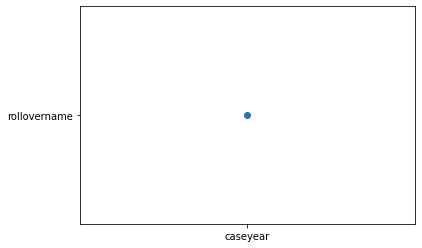

In [445]:
plt.scatter("caseyear","rollovername")

7.3) Determine the features which useful to explain the car rollover phenomenon.<br>
**Reminder**: Determine **at most 30** features. It is not saying that report 30 features. Maybe, after the top 20 features, others have much less importance. You should report a short-listed features.

You can follow several strategies:
- Using ```coef_``` attribute of linear models
- Using ```feature_log_prob_``` attribute of probabilistic models
- Using ```feature_importances_``` attribute of the decision-tree based models
- Using ```permutation_importance``` function of sklearn (**REQUIRED** to explain how it works in the report)
    
You can either rely on the best model or all models to determine the good features.
For example, if you have multiple successful models, you can determine the common important features for them. 
    
After the creating a short-listed features, you can ensure whether they are enough to explain the phenemona via observing performances of re-trained model(s) using only these features.

In [403]:
data

,caseyear,statename,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,incomplt,ve_forms,per_no,hourname,harm_evname,sch_busname,rollover,rollovername,agename,sexname,per_typname,seat_posname,rest_usename,rest_misname,air_bagname,ejectionname,ej_pathname,drinkingname,drugsname,dstatusname,work_injname,hispanicname
0,2014,Alabama,2011.0,Passenger Car,STANDARD,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,2734.0,15600.0,Front Wheel Drive,Non Luxury,Canada,Import,4.0,16.0,N,1,1,1:00am-1:59am,Boulder,No,1.0,Rollover,Young,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",Shoulder and Lap Belt Used,No,Deployed,Not Ejected,Not Ejected/Not Applicable,Yes (Alcohol Involved),Unknown,Test Given,No,Non-Hispanic
1,2014,Alabama,2011.0,Passenger Car,STANDARD,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,2734.0,15600.0,Front Wheel Drive,Non Luxury,Canada,Import,4.0,16.0,N,1,2,1:00am-1:59am,Boulder,No,1.0,Rollover,Young,Female,Passenger of a Motor Vehicle In-Transport,"Front Seat, Right Side",Shoulder and Lap Belt Used,No,Deployed,Not Ejected,Not Ejected/Not Applicable,Not Reported,Not Reported,Test Not Given,Not Applicable (not a fatality),Non-Hispanic
2,2014,Alabama,1997.0,Truck,TRUCK,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,4787.0,20775.0,Rear Wheel Drive,Non Luxury,Mexico,Domestic,2.0,16.0,N,1,1,1:00pm-1:59pm,Tree (Standing Only),No,0.0,No Rollover,Mid-Aged,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",None Used,No,Deployed,Not Ejected,Not Ejected/Not Applicable,Yes (Alcohol Involved),No (drugs not involved),Test Given,No,Non-Hispanic
3,2014,Alabama,2004.0,Passenger Car,STANDARD,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,3315.0,23495.0,Front Wheel Drive,Non Luxury,United States,Domestic,0.0,0.0,N,2,1,3:00am-3:59am,Motor Vehicle In-Transport,No,0.0,No Rollover,Young,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",None Used,No,Not Deployed,Not Ejected,Not Ejected/Not Applicable,Unknown (Police Reported),Unknown,Test Not Given,Not Applicable (not a fatality),Non-Hispanic
4,2014,Alabama,2004.0,Passenger Car,STANDARD,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,3315.0,23495.0,Front Wheel Drive,Non Luxury,United States,Domestic,0.0,0.0,N,2,2,3:00am-3:59am,Motor Vehicle In-Transport,No,0.0,No Rollover,Young,Female,Passenger of a Motor Vehicle In-Transport,"Front Seat, Right Side",Shoulder and Lap Belt Used,No,Deployed,Not Ejected,Not Ejected/Not Applicable,Not Reported,Not Reported,Test Not Given,Not Applicable (not a fatality),Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452905,2019,Wyoming,2010.0,Truck,SPORT,4.0,4.0,4.0,HYUNDAI,212.0,6.0,Gas,4120.0,30295.0,All Wheel Drive,Non Luxury,United States,Import,4.0,24.0,N,1,1,4:00am-4:59am,Embankment,No,1.0,Rollover,Young,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",None Used/Not Applicable,No,Deployed,Totally Ejected,Ejection Path Unknown,Yes (Alcohol Involved),Yes (drugs involved),Test Given,No,Non-Hispanic
452906,2019,Wyoming,2010.0,Truck,SPORT,4.0,4.0,4.0,HYUNDAI,212.0,6.0,Gas,4120.0,30295.0,All Wheel Drive,Non Luxury,United States,Import,4.0,24.0,N,1,2,4:00am-4:59am,Embankment,No,1.0,Rollover,Young,Male,Passenger of a Motor Vehicle In-Transport,"Front Seat, Right Side",None Used/Not Applicable,No,Deployed,Not Ejected,Ejection Path Not Applicable,Not Reported,Not Reported,Test Not Given,Not Applicable (not a fatality),Non-Hispanic
452907,2019,Wyoming,2013.0,Passenger Car,STANDARD,4.0,4.0,2.0,DAIMLER-CHRYSLER,122.0,4.0,Gas,3186.0,17995.0,Front Wheel Drive,Non Luxury,United States,Domestic,4.0,16.0,N,2,1,11:00pm-11:59pm,Motor Vehicle In-Transport,No,0.0,No Rollover,Mid-Aged,Male,Driver of a Motor Vehicle In-Transport,"Front Seat, Left Side",Shoulder and Lap Belt Used,No,Deployed,Not Ejected,Ejection Path Not 

In [404]:
data.columns

Index(['caseyear', 'statename', 'vinyear', 'vehtype_t', 'bodystyl_t', 'doors',
       'wheels', 'drivwhls', 'mfg_t', 'displci', 'cylndrs', 'fuel_t',
       'shipweight', 'msrp', 'drivetyp_t', 'segmnt_t', 'plntctry_t',
       'origin_t', 'vlvclndr', 'vlvtotal', 'incomplt', 've_forms', 'per_no',
       'hourname', 'harm_evname', 'sch_busname', 'rollover', 'rollovername',
       'agename', 'sexname', 'per_typname', 'seat_posname', 'rest_usename',
       'rest_misname', 'air_bagname', 'ejectionname', 'ej_pathname',
       'drinkingname', 'drugsname', 'dstatusname', 'work_injname',
       'hispanicname'],
      dtype='object')

In [408]:
feature_log_prob_

Object `feature_log_prob_` not found.


In [411]:
feature_importances_

NameError: name 'feature_importances_' is not defined

# Permutation_importance for Logistic Regression

In [418]:
pi_lr_result = permutation_importance(lr, x_test_lr_std, y_test_lr) #n_repeats=10
pi_lr_result

{'importances_mean': array([ 1.52025743e-05, -4.22293731e-05,  7.56750365e-04,  1.81248469e-03,
         3.98645282e-04,  7.26345217e-05,  3.54726734e-05, -4.39185480e-05,
        -1.50336568e-04, -2.02700991e-05, -1.23309769e-04, -8.44587461e-06,
        -3.20943235e-05, -1.68917492e-05,  8.37830762e-04,  5.06752477e-05,
         8.44587461e-05, -1.28377294e-04,  2.36484489e-05,  6.75669969e-06,
         5.91211223e-05,  1.65843194e-02,  1.98140218e-03, -5.23644226e-05,
        -5.96278748e-04,  2.65200463e-04,  1.73985017e-04, -5.40535975e-05,
         4.67901454e-04,  1.48985228e-03, -1.60471618e-04,  5.67562774e-04,
        -2.02700991e-05, -9.52694656e-04,  4.55874528e-02,  1.01350495e-04,
         4.89860728e-05, -7.93912214e-05,  2.36484489e-05, -7.53372015e-04,
        -1.60471618e-04]),
 'importances_std': array([2.35274842e-05, 3.92528781e-05, 1.75917654e-04, 8.75442506e-05,
        2.09307791e-04, 3.68534459e-05, 7.33187538e-05, 8.21293454e-05,
        1.14739623e-04, 4.2263

# feature_importances_ for Random Forests

In [415]:
rf.feature_importances_

array([6.21191580e-03, 7.39506030e-05, 2.88257897e-02, 1.54722940e-02,
       4.58880803e-03, 1.37908711e-04, 4.52861660e-03, 2.77417269e-03,
       2.34442531e-04, 9.66673159e-03, 2.16231407e-03, 5.19687805e-04,
       4.03261394e-03, 1.36546289e-03, 1.51599085e-02, 4.12094803e-05,
       1.16975093e-04, 6.92260516e-04, 5.46839635e-03, 3.57458416e-03,
       0.00000000e+00, 2.25065146e-01, 8.35156937e-03, 8.84272969e-05,
       1.54427669e-01, 0.00000000e+00, 1.17043586e-03, 6.05805997e-05,
       4.08103926e-03, 6.94059346e-02, 7.59969720e-03, 6.80788190e-02,
       0.00000000e+00, 5.67877259e-03, 2.19655854e-01, 7.38930485e-02,
       1.56539075e-02, 1.45625383e-03, 2.21609802e-03, 3.66156827e-02,
       8.53021348e-04])

In [465]:
x_1 = ["ejectionname","ej_pathname","vinyear","rest_usename"]


In [467]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(pd.get_dummies(data[x_1]), y, test_size=0.3)

scale_1 = StandardScaler()

x_train_1_std = scale_1.fit_transform(x_train_1)

x_test_1_std = scale_1.transform(x_test_1)

lr_1 = LogisticRegression()

lr_1.fit(x_train_1_std, y_train_1)

pred_y_test_1 = lr_1.predict(x_test_1_std)


lr_1.score(x_test_1_std, y_test_1)

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.848717493940085

In [469]:
x_2 = ["ejectionname","ej_pathname","drinkingname","drivetyp_t" ]

In [470]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(pd.get_dummies(data[x_2]), y, test_size=0.3)

scale_2 = StandardScaler()

x_train_2_std = scale_2.fit_transform(x_train_2)

x_test_2_std = scale_2.transform(x_test_2)

lr_2 = LogisticRegression()

lr_2.fit(x_train_2_std, y_train_2)

pred_y_test_2 = lr_2.predict(x_test_2_std)


lr_2.score(x_test_2_std, y_test_2)

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8479658110995684

In [471]:
x_3 = ["statename","vinyear","vehtype_t","bodystyl_t","mfg_t","cylndrs","fuel_t","shipweight","msrp","drivetyp_t","segmnt_t","plntctry_t","origin_t","vlvclndr","vlvtotal","incomplt","ve_forms","per_no","hourname","harm_evname","agename","sexname","per_typname","rest_usename","rest_misname","air_bagname","ejectionname","ej_pathname"]

In [472]:
len(x_3)

28

In [473]:
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(pd.get_dummies(data[x_3]), y, test_size=0.3)

scale_3 = StandardScaler()

x_train_3_std = scale_3.fit_transform(x_train_3)

x_test_3_std = scale_3.transform(x_test_3)

lr_3 = LogisticRegression()

lr_3.fit(x_train_3_std, y_train_3)

pred_y_test_3 = lr_3.predict(x_test_3_std)


lr_3.score(x_test_3_std, y_test_3)

C:\Users\MONSTER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8874671666624437